<a href="https://colab.research.google.com/github/willians124/ML/blob/master/Parcial_Regresi%C3%B3n_Log%C3%ADstica.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **0.-Importamos las librerías a usar**

In [1]:
!pip install lightgbm

In [0]:
import pandas as pd
from sklearn import preprocessing
import numpy as np
import gc
import lightgbm as lgb
from scipy import sparse
from scipy.sparse.linalg import svds
from sklearn.metrics import roc_auc_score
from scipy.sparse import csr_matrix
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
from sklearn.metrics import log_loss
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
import seaborn as sns
from sklearn.impute import SimpleImputer
from statistics import mode 


In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

# **1.Leer los datos del dataset**
## Leer los datos del dataset

In [616]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
datos = pd.read_excel("/content/drive/My Drive/2019-2/2.INTELIGENCIA ARTIFICIAL/IA 2019 2 GRUPAL/PARCIAL/ae1.dataset.xls")

In [618]:
datos.head(20)

,Cliente,Edad,Renta,Sexo,EstadoCivil,NivelSocioEconomico,Departamento,AntiguedadCuenta_Meses,RegistraAdicionales,NumeroAdicionales,AntiguedadAdicionales_Meses,LineaCreditoNormal,SituacionCuenta,PromediodePagos,SaldoExtra,SaldoNormal,SaldoTotal,HabitodePago1,HabitodePago2,HabitodePago3,HabitodePago4,HabitodePago5,HabitodePago6,HabitodePago7,HabitodePago8,PeorHabito Pago,FlagRefinanciadoHistórico,FlagRefinanciado,DiasMora200812,DiasMora200901,DiasMora200902,DiasMora200903,DiasMora200904,DiasMora200905,CódigoInstitucion,PagaDespues,DispEfectivo,CalificacionSBS,CompraAnual_200806_200905,NroTransaccionesAnual_200806_200905,CompraMensualMaxima_200806_200905,Flag_Cliente
0,514,35,1703.0,M,S,N,AREQUIPA,74.13,0,NaN,NaN,2100,0,2,2331,131,2461,1,1,1,1,1,1,9,4,0.0,N/V,No Registró,0.0,0,0,0,0,0,0.0,0,0,0,133.20,8.0,66.00,MALO
1,728,29,NaN,M,S,C,LIMA,74.10,0,NaN,NaN,1100,0,9,0,1405,1405,A,B,A,4,B,B,A,4,0.0,Ref.C,Registró Refinanciación,82.0,0,18,49,20,51,0.0,1,0,2,772.69,32.0,225.26,MALO
2,2387,25,850.0,F,S,C,LIMA,53.30,0,NaN,NaN,600,0,7,0,2700,2700,B,A,B,A,4,1,4,1,0.0,Ref.C,Registró Refinanciación,0.0,16,44,16,46,0,0.0,0,0,3,653.89,10.0,526.30,MALO
3,3445,31,NaN,M,S,D,LIMA,73.90,1,1.0,13.10,600,5,9,0,443,443,4,C,B,B,A,4,9,A,0.0,N/V,No Registró,41.0,42,70,0,10,11,0.0,0,0,4,1354.32,19.0,468.00,MALO
4,6536,35,NaN,M,S,N,LA LIBERTAD,73.70,0,NaN,NaN,1800,5,6,3799,3786,7585,B,A,4,9,4,2,2,4,0.0,N/V,No Registró,6.0,37,3,34,36,67,0.0,1,2,2,459.10,3.0,439.20,MALO
5,7355,43,2957.0,M,S,C,LIMA,73.67,0,NaN,NaN,2500,5,B,0,1268,1268,B,A,B,A,B,A,A,B,NaN,N/V,No Registró,6.0,37,65,34,64,6,0.0,0,0,3,1806.98,37.0,1077.28,MALO
6,9164,32,800.0,F,S,N,PIURA,73.57,0,NaN,NaN,3600,5,8,1008,3245,4253,B,A,4,2,9,A,A,B,NaN,N/V,No Registró,0.0,1,0,31,61,31,0.0,0,0,3,4088.74,65.0,1289.00,MALO
7,14111,31,550.0,F,S,D,LIMA,73.30,0,NaN,NaN,500,5,7,0,537,537,A,A,4,4,1,B,A,4,NaN,N/V,No Registró,0.0,0,0,26,25,56,400.0,0,1,3,658.97,17.0,305.50,MALO
8,15541,40,NaN,M,S,N,PIURA,58.63,0,NaN,NaN,850,5,3,278,1065,1343,A,4,2,2,1,1,1,1,NaN,N/V,No Registró,1.0,1,0,1,31,62,0.0,0,0,2,213.14,15.0,129.50,MALO
9,18808,26,NaN,F,S,C,LIMA,72.93,1,2.0,35.93,400,5,D,0,848,848,D,D,D,D,D,D,D,D,NaN,N/V,No Registró,112.0,113,110,111,110,110,0.0,0,0,4,121.65,3.0,61.80,MALO


# Identifique número de filas y columnas

In [619]:
print("Número de filas : ",str(datos.shape[0]),"y Número de columnas : " ,str(datos.shape[1]))

Número de filas :  7100 y Número de columnas :  42


# Extraiga una lista de los atributos.

In [620]:
print('Atributos del dataset')
datos.info()

Atributos del dataset
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7100 entries, 0 to 7099
Data columns (total 42 columns):
Cliente                                7100 non-null int64
Edad                                   7100 non-null int64
Renta                                  3560 non-null float64
Sexo                                   7100 non-null object
EstadoCivil                            7100 non-null object
NivelSocioEconomico                    7100 non-null object
Departamento                           7100 non-null object
AntiguedadCuenta_Meses                 7100 non-null float64
RegistraAdicionales                    7100 non-null int64
NumeroAdicionales                      2361 non-null float64
AntiguedadAdicionales_Meses            2361 non-null float64
LineaCreditoNormal                     7100 non-null int64
SituacionCuenta                        7100 non-null int64
PromediodePagos                        7100 non-null object
SaldoExtra                      

# **2.Frecuencia Incial**
Determinar la frecuencia de BUENOS y MALOS en los datos, de tal forma que se puede armar muestras. Calcule el nivel de entropía e interprete los resultados.

In [621]:
pd.value_counts(datos['Flag_Cliente'])

MALO     3550
BUENO    3550
Name: Flag_Cliente, dtype: int64

In [622]:
100 * datos['Flag_Cliente'].value_counts() / len(datos['Flag_Cliente'])

MALO     50.0
BUENO    50.0
Name: Flag_Cliente, dtype: float64

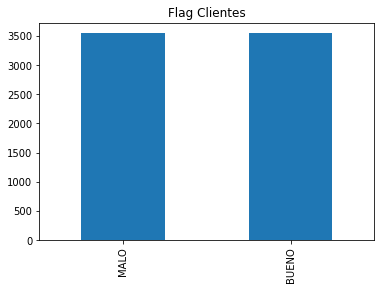

In [623]:
plot = datos['Flag_Cliente'].value_counts().plot(kind='bar',
                                            title='Flag Clientes')


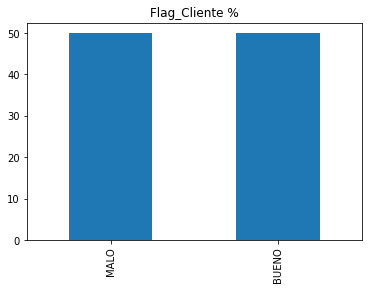

In [624]:

plot = (100 * datos['Flag_Cliente'].value_counts() / len(datos['Flag_Cliente'])).plot(
kind='bar', title='Flag_Cliente %')

# **3.Muestreo Inicial**
Dividir los datos en dos grupos del 50% y 50% respectivamente, al que se denominara TRAIN y TEST.

In [0]:
Train,Test = train_test_split(datos, test_size=0.5, train_size=0.5,random_state=1982)

# **4.Balanceo de Datos**
Balancear los datos. Solo con los datos de TEST, maximize el tamaño de la muestra balanceada.

Solo se balancea el TRAIN y el TEST se deja igual.


In [626]:
Train.shape , Test.shape

((3550, 42), (3550, 42))

In [627]:
pd.value_counts(Train['Flag_Cliente']),pd.value_counts(Test['Flag_Cliente'])

(MALO     1778
 BUENO    1772
 Name: Flag_Cliente, dtype: int64, BUENO    1778
 MALO     1772
 Name: Flag_Cliente, dtype: int64)

In [628]:
pd.value_counts(Train['Flag_Cliente'])

MALO     1778
BUENO    1772
Name: Flag_Cliente, dtype: int64

In [629]:
Train_Malo_undersampling=Train_Malo=Train.loc[Train.loc[:,'Flag_Cliente']=='MALO'].sample(n=1772, replace=False)
Train_Malo_undersampling.shape

(1772, 42)

In [0]:
frames = [Train_Malo_undersampling,Train.loc[Train.loc[:,'Flag_Cliente']=='BUENO']]
Train_Balanceado =pd.concat(frames)

In [631]:
pd.value_counts(Train_Balanceado['Flag_Cliente'])

MALO     1772
BUENO    1772
Name: Flag_Cliente, dtype: int64

# **5.Ranking de atributos**
Preparar el ranking de atributos solo con los datos balanceados (usar el operador weight). Solo con los datos balanceados.

# **6.Descripción de los datos**
Preparar la descripción de los datos, con estadística Univariada y multivarida, exponer los atributos en función al ranking de atributos, primero el más importante. Solo con los datos balanceados.

In [0]:
df_train=Train_Balanceado.copy()

In [0]:
feature_columns = {}

feature_columns['categorical'] = df_train.select_dtypes(include = ['object']).columns.values.tolist()
feature_columns['int'] = df_train.select_dtypes(include = ['integer']).columns.values.tolist()
feature_columns['float'] = df_train.select_dtypes(include = ['float32','float64']).columns.values.tolist()
feature_columns['numerical'] = feature_columns['int'] + feature_columns['float']
feature_columns["categorical"]
del feature_columns["categorical"][-1]
del feature_columns["numerical"][0]
del feature_columns["int"][0]


In [0]:
Train_Balanceado=df_train.copy()

In [635]:
feature_columns["categorical"]

['Sexo',
 'EstadoCivil',
 'NivelSocioEconomico',
 'Departamento',
 'PromediodePagos',
 'HabitodePago1',
 'HabitodePago2',
 'HabitodePago3',
 'HabitodePago4',
 'HabitodePago5',
 'HabitodePago6',
 'HabitodePago7',
 'HabitodePago8',
 'FlagRefinanciadoHistórico',
 'FlagRefinanciado']

In [0]:
df_train=Train_Balanceado.copy()

In [0]:
Train_Balanceado=df_train.copy()

In [0]:
Train_Balanceado=Train_Balanceado.reset_index(drop=True)

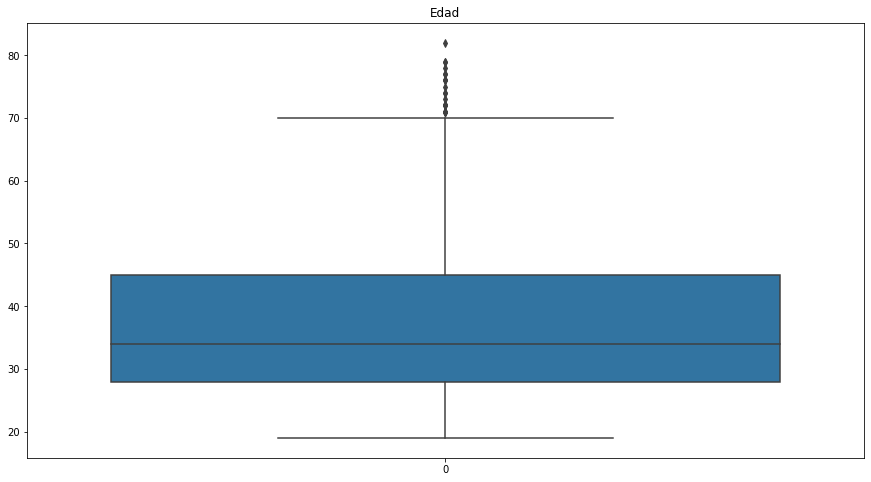

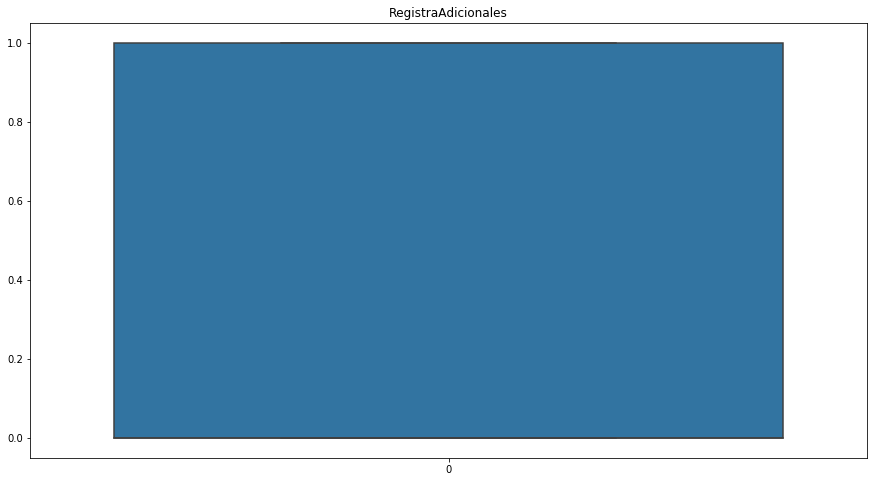

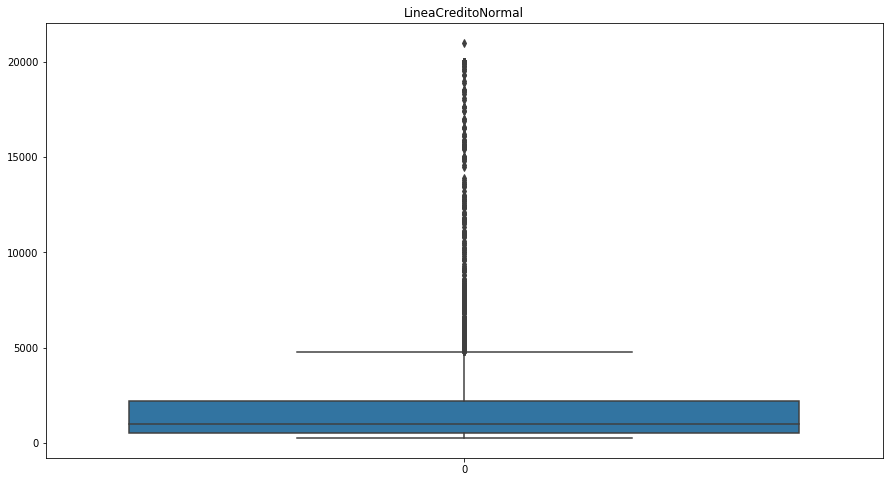

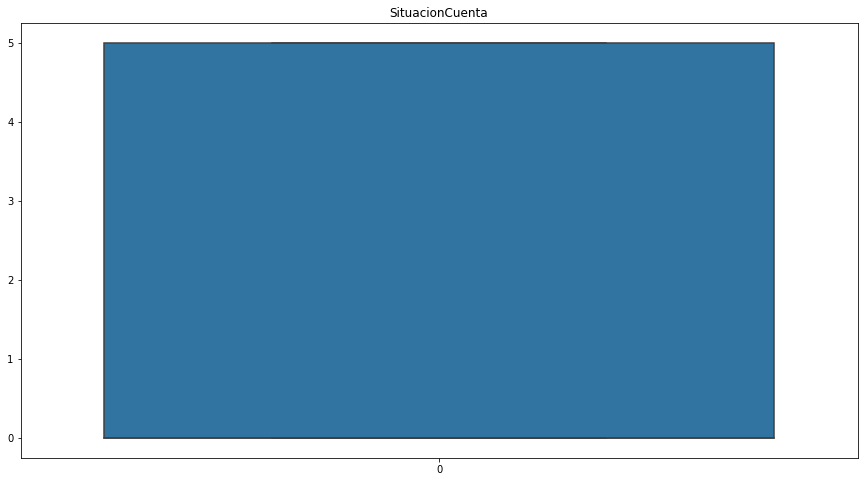

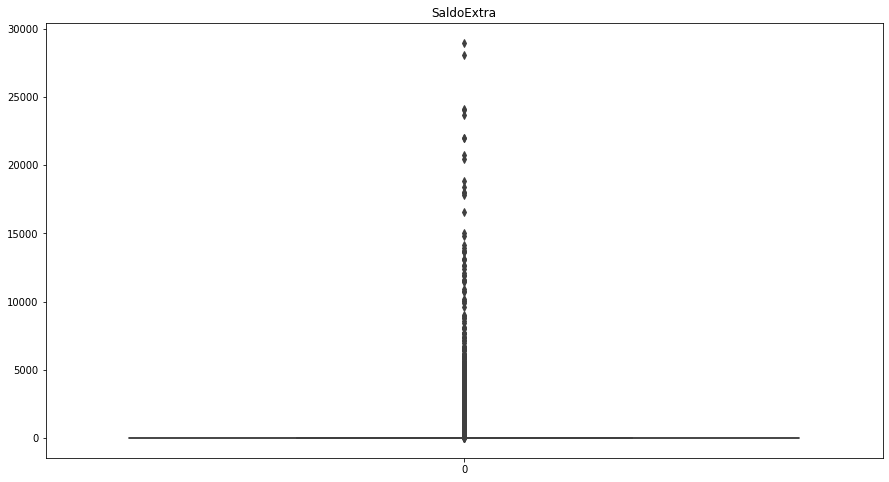

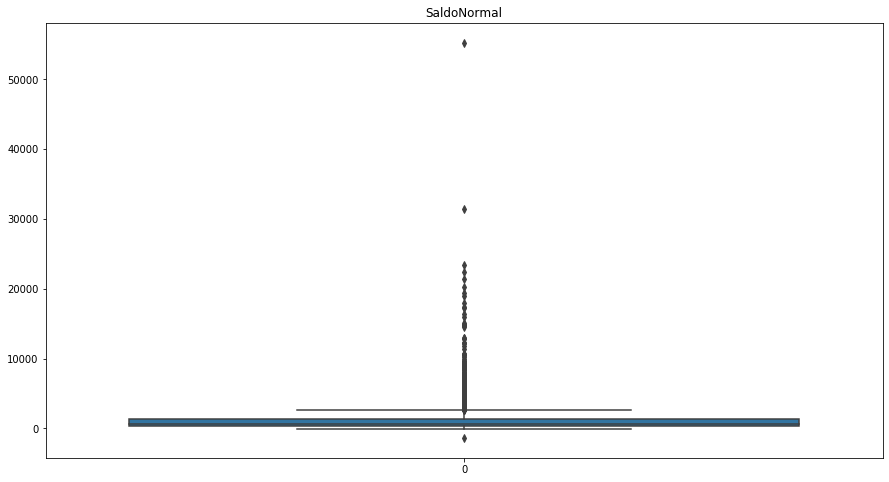

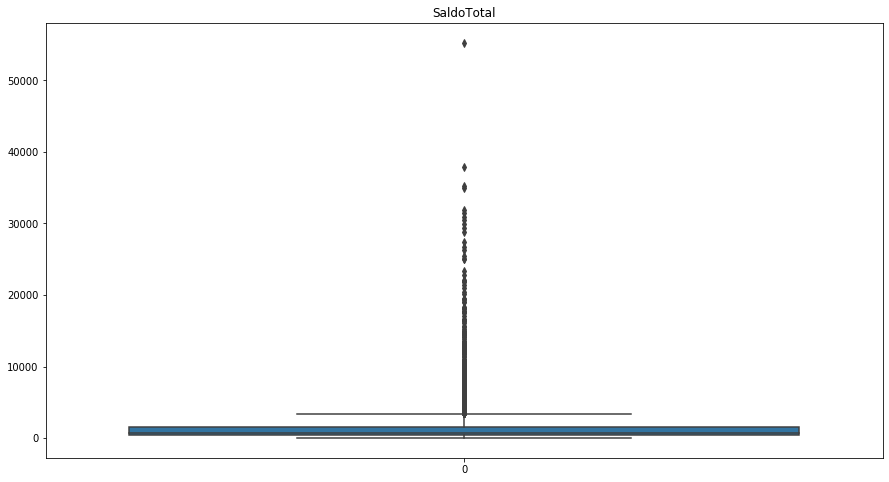

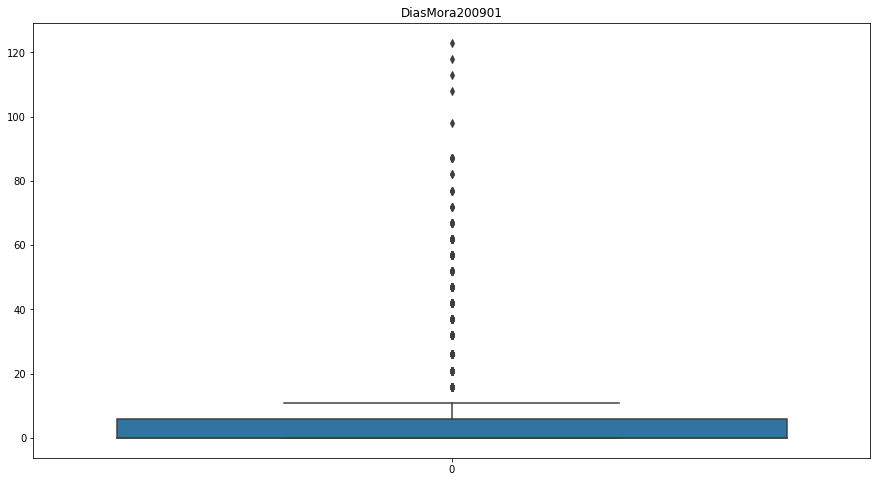

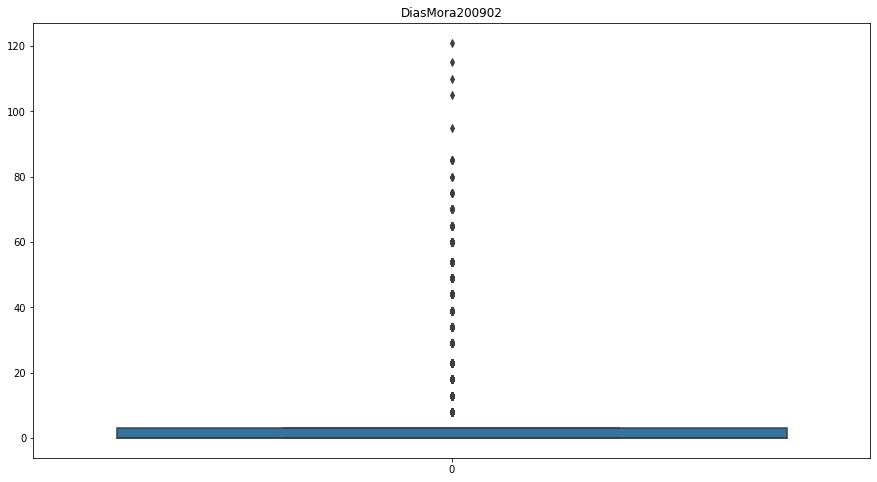

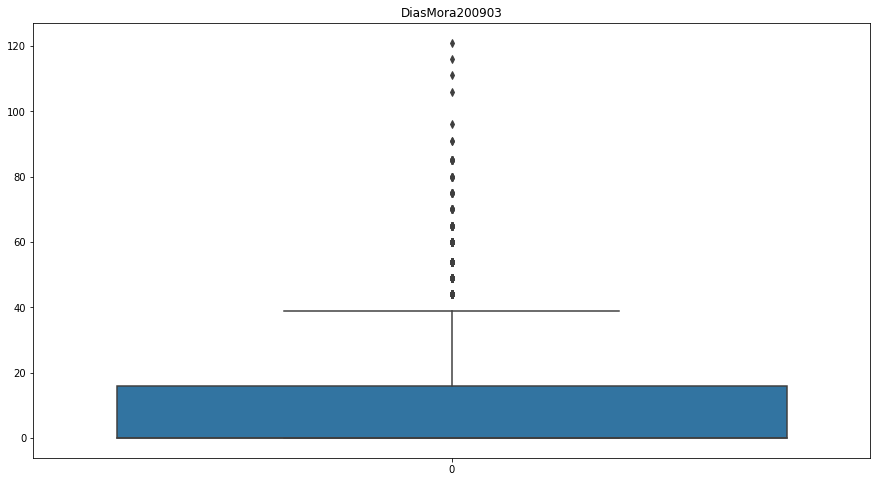

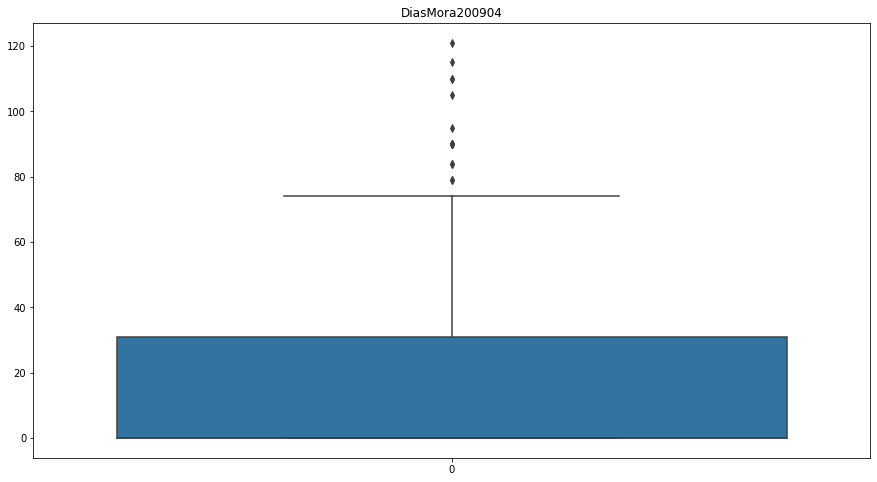

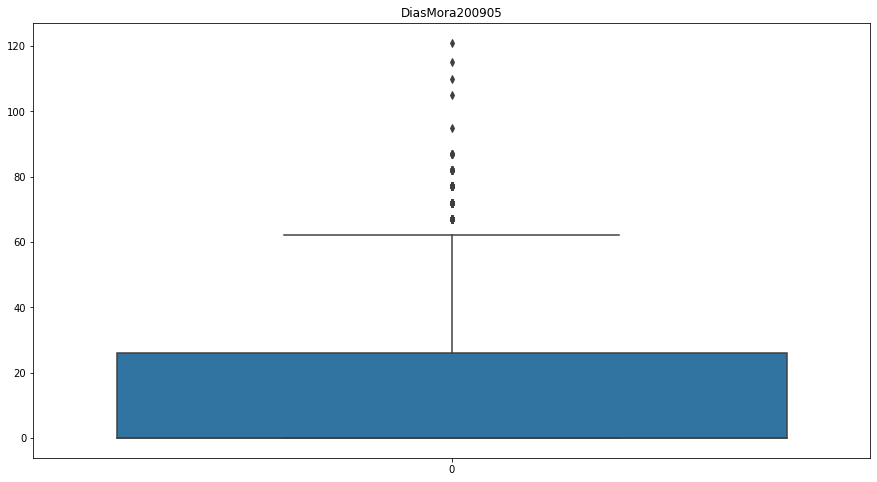

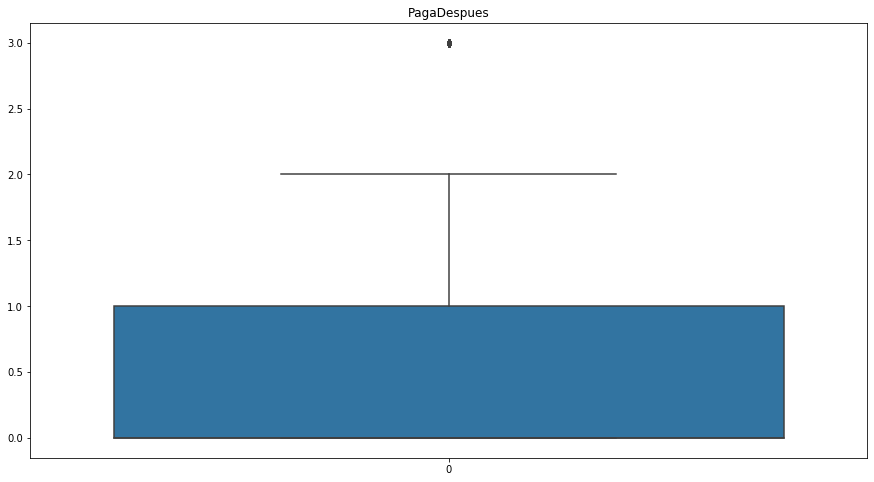

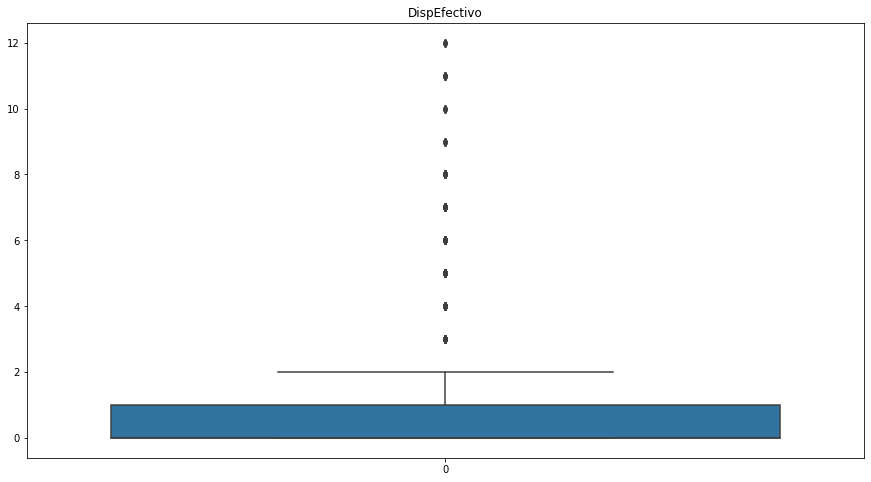

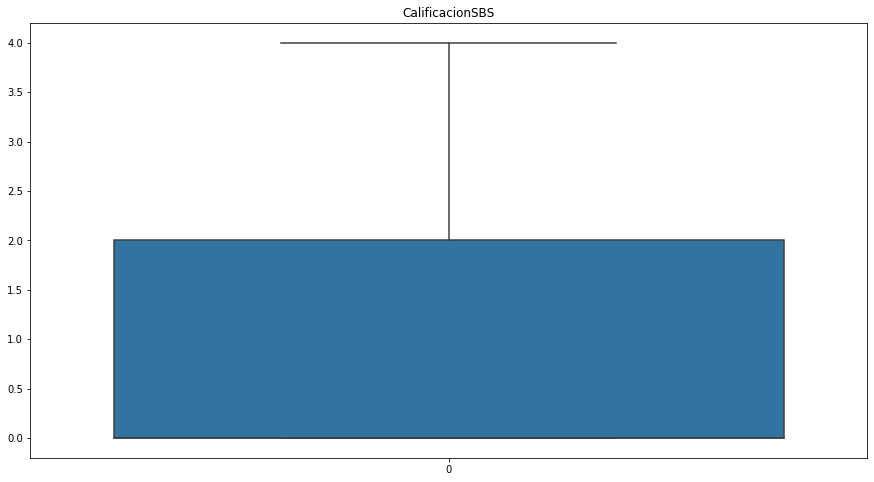

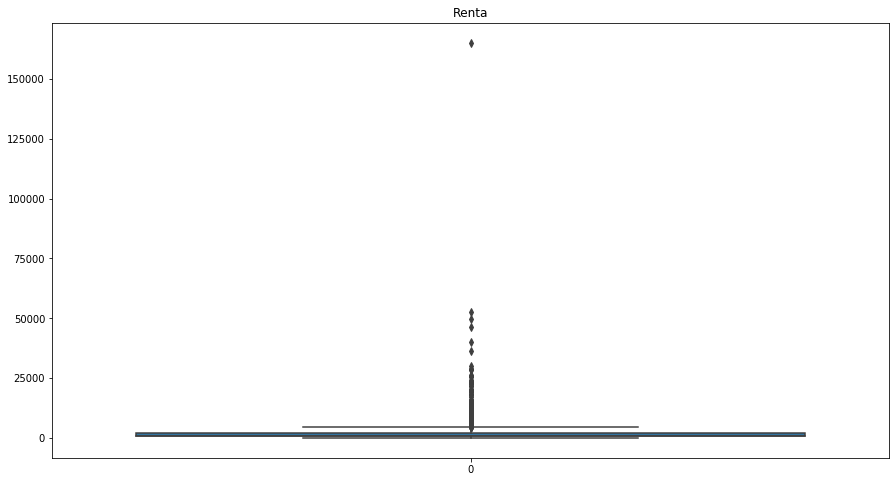

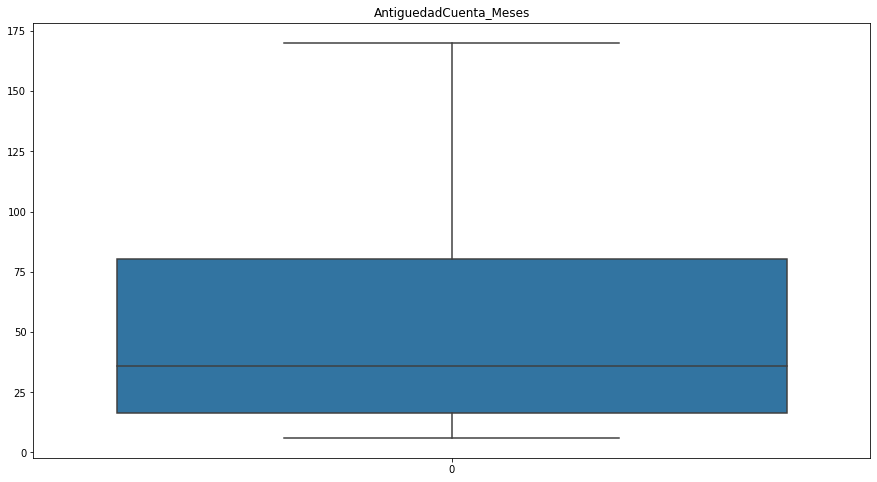

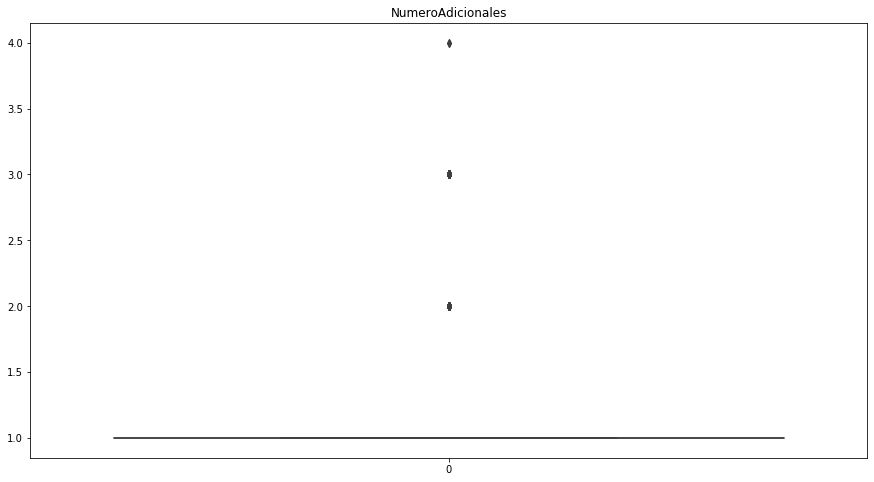

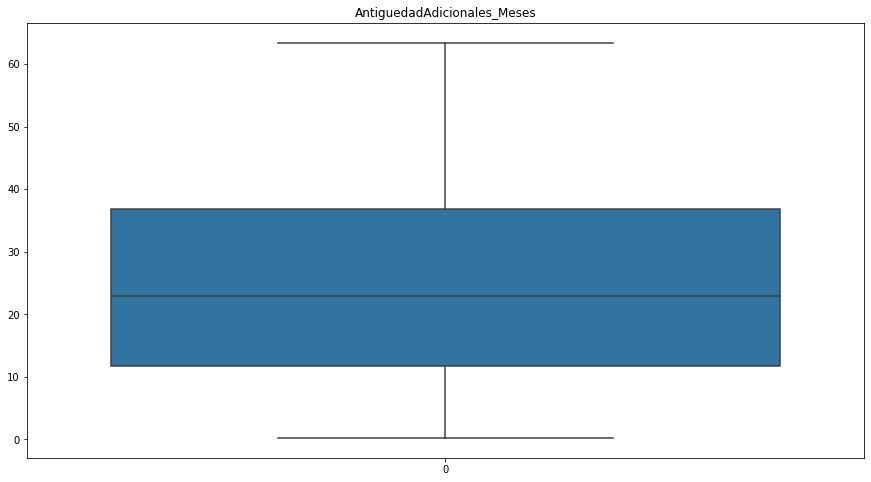

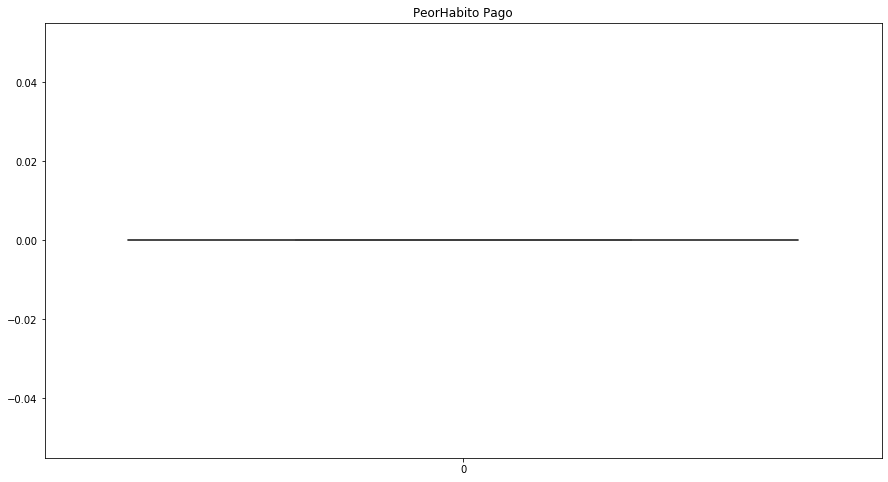

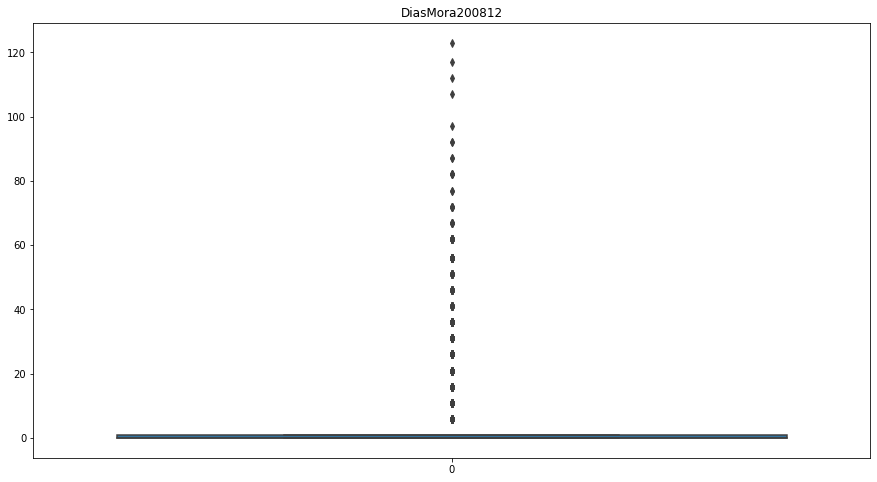

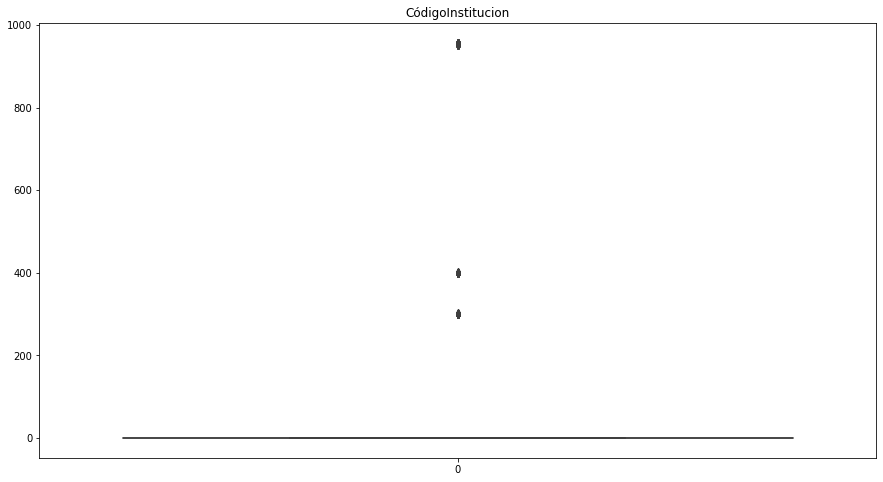

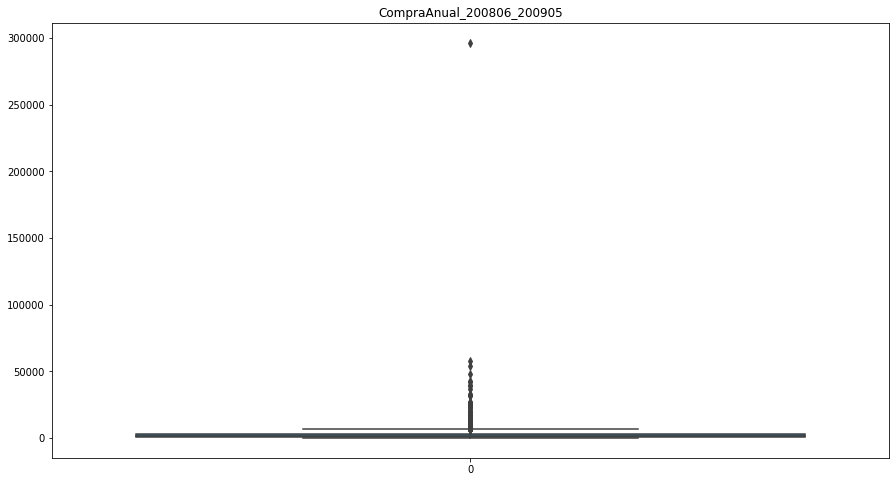

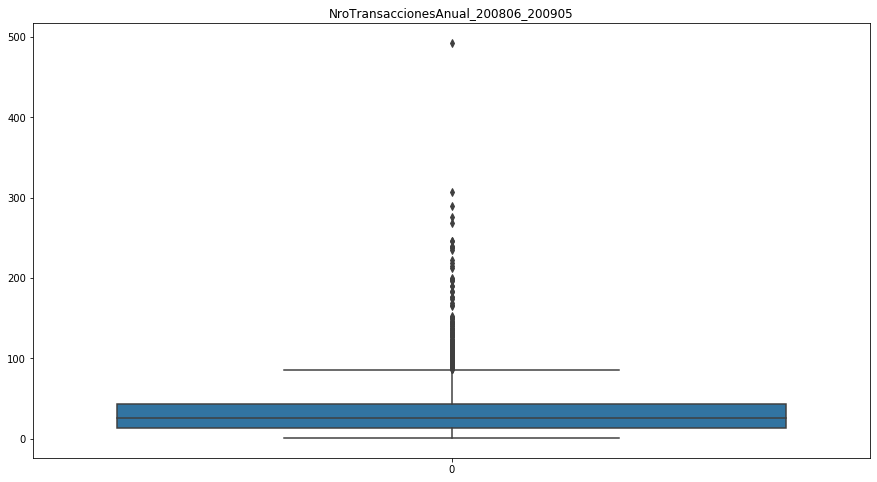

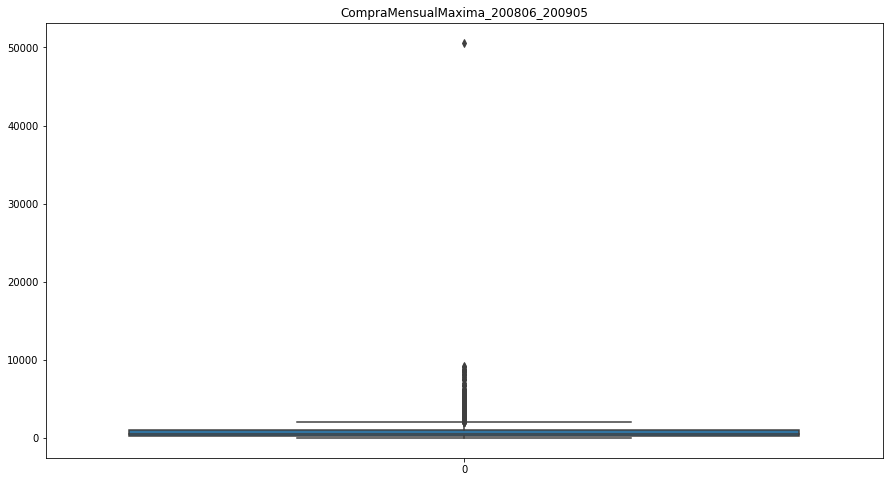

In [577]:
for cat in feature_columns["numerical"]:
  
  plt.figure(figsize=(15,8))
  sns.boxplot(data=Train_Balanceado.loc[:,cat])
  plt.title(cat)
  plt.show()
  import gc
  gc.collect()

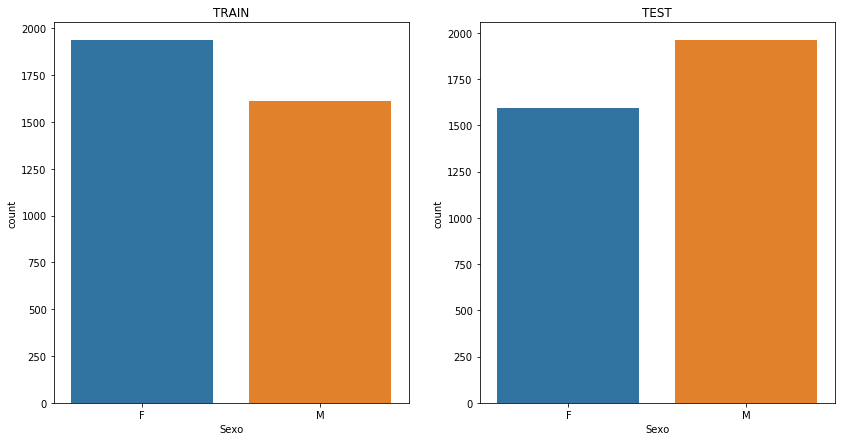

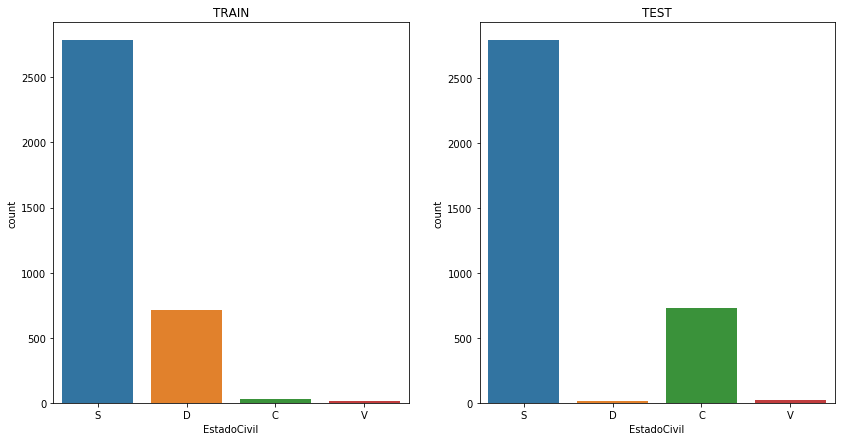

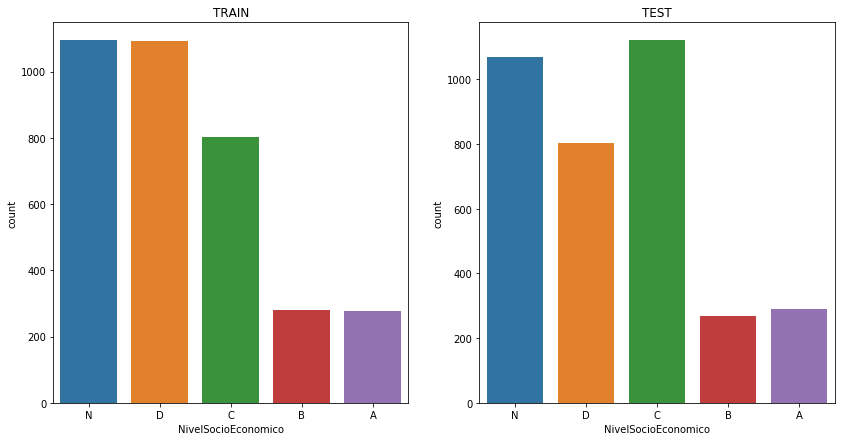

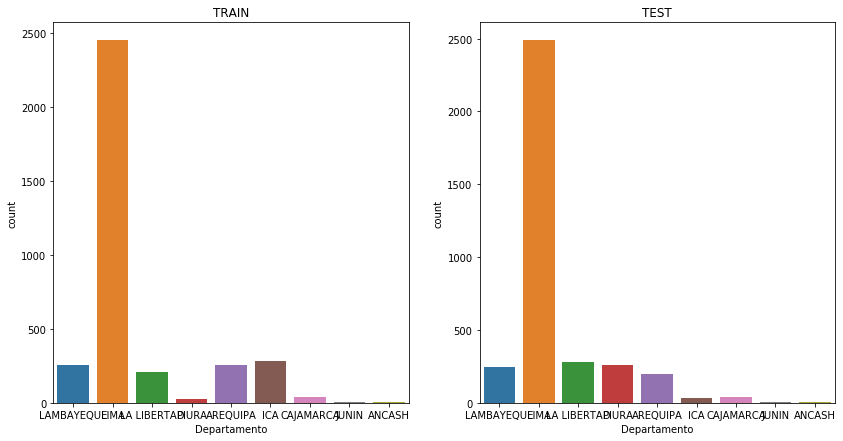

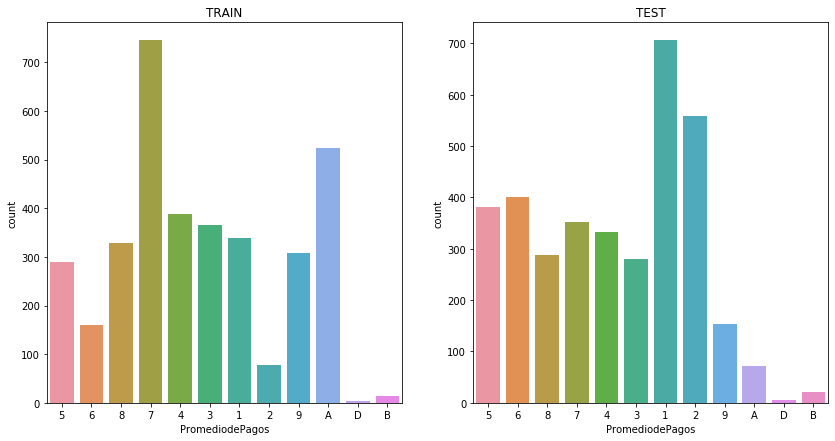

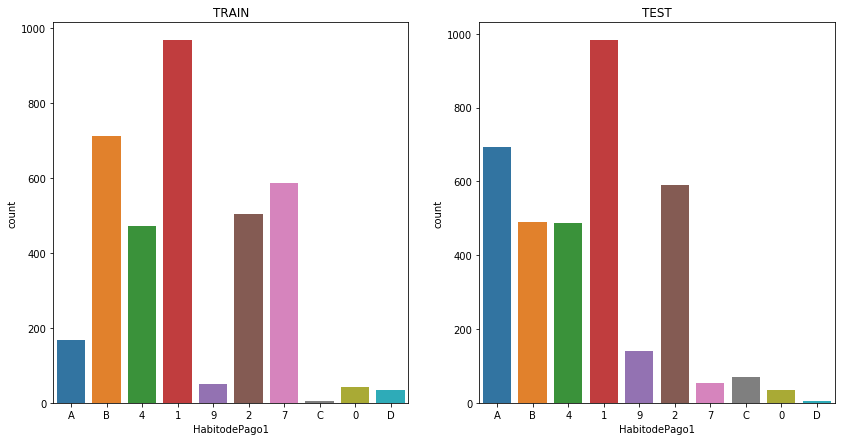

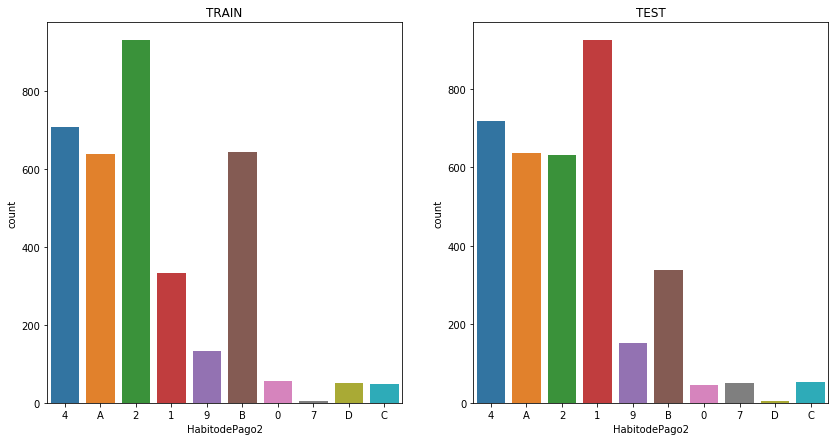

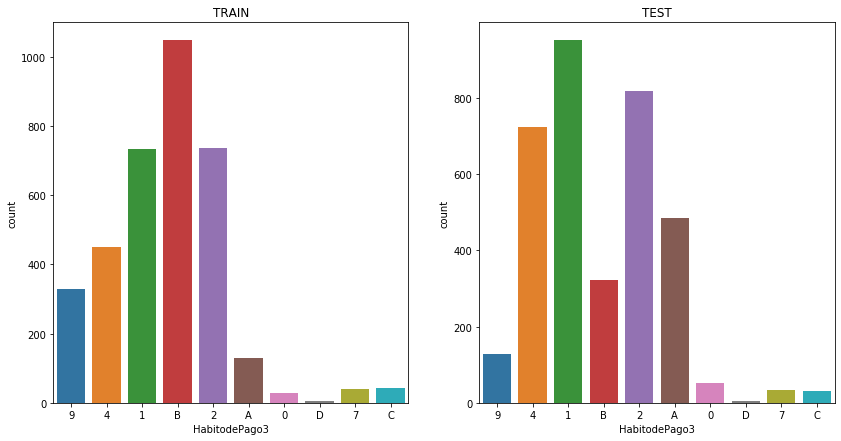

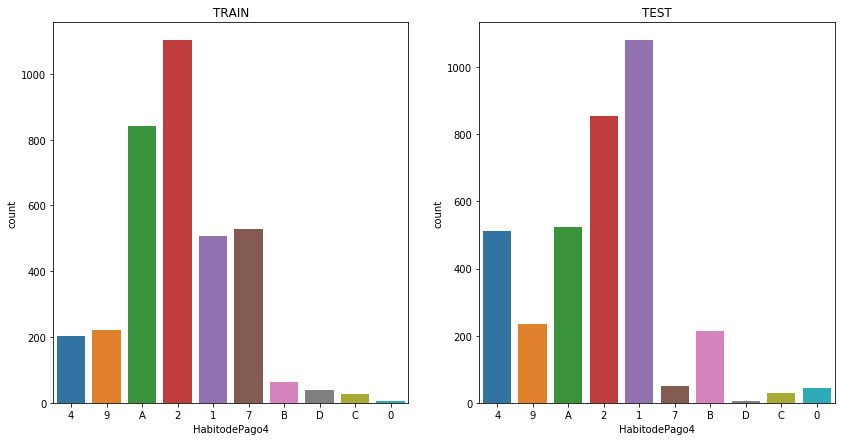

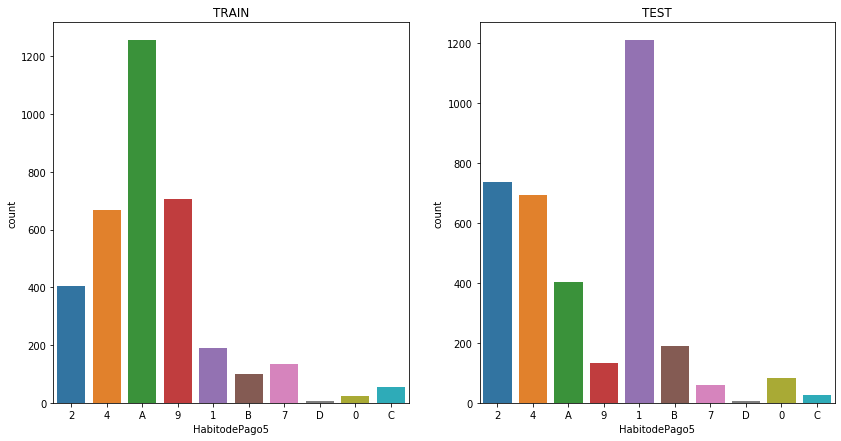

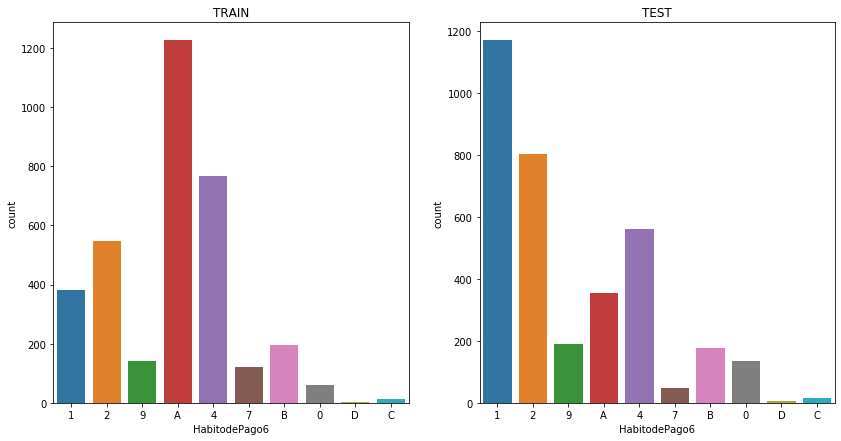

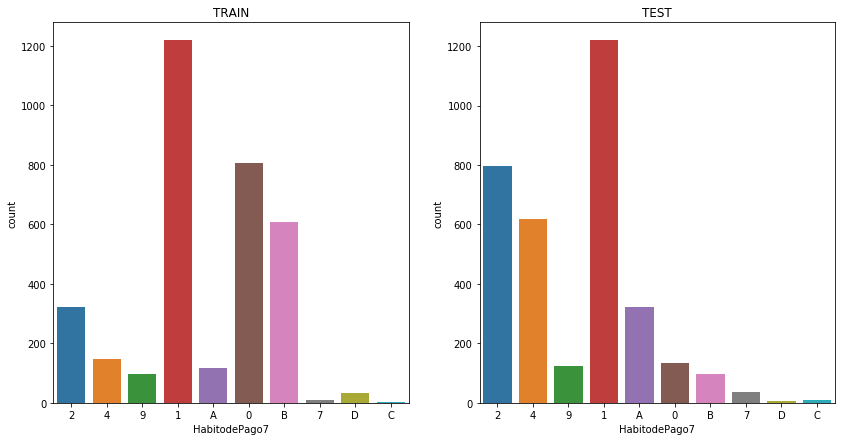

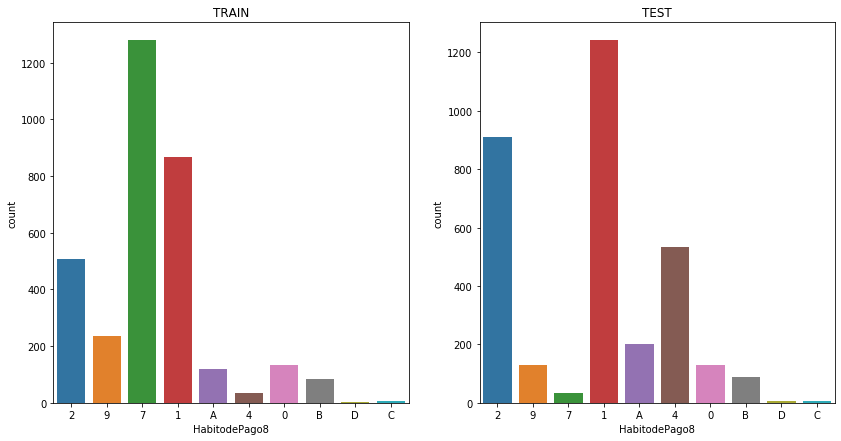

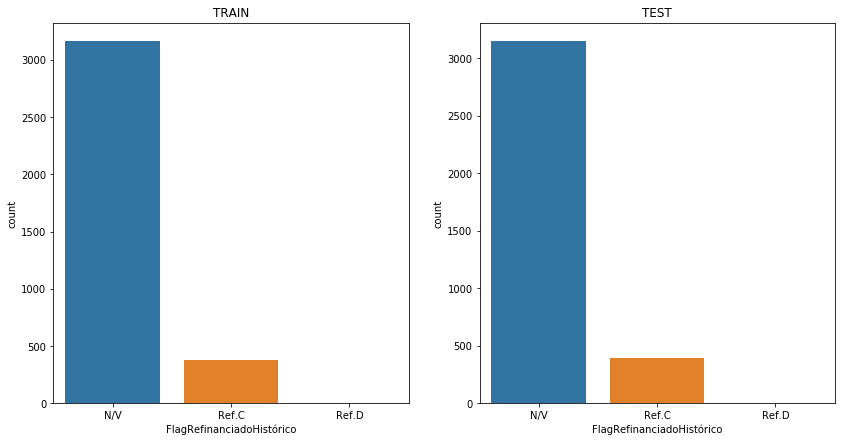

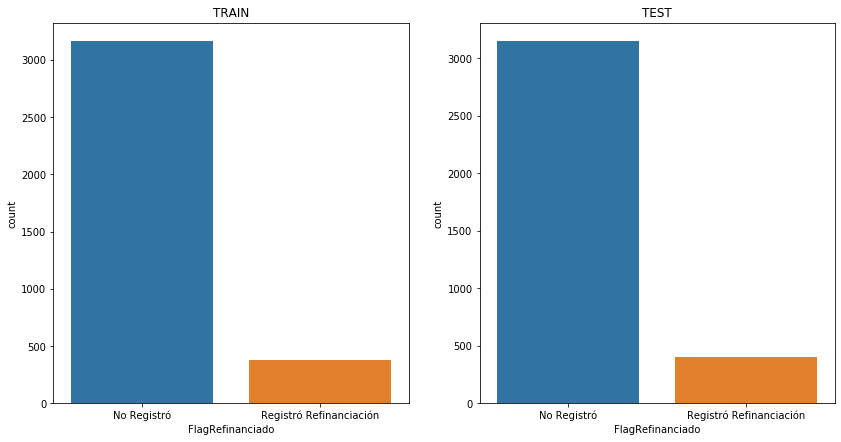

In [27]:
for cat in feature_columns["categorical"]:

  f, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,7), sharex=True)
  sns.countplot(x=cat,data=Train_Balanceado,ax=ax1)
  ax1.set_title("TRAIN")
  sns.countplot(x=cat,data=Test,ax=ax2)
  ax2.set_title("TEST")
  plt.show()
  import gc
  gc.collect()


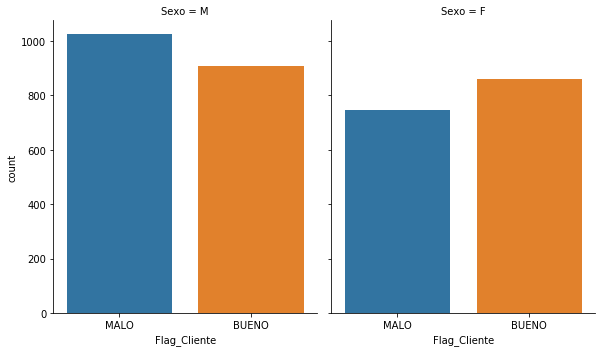

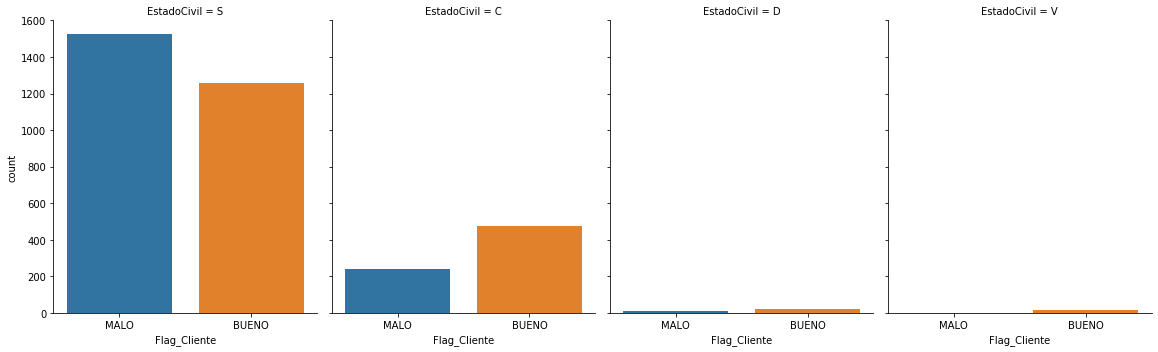

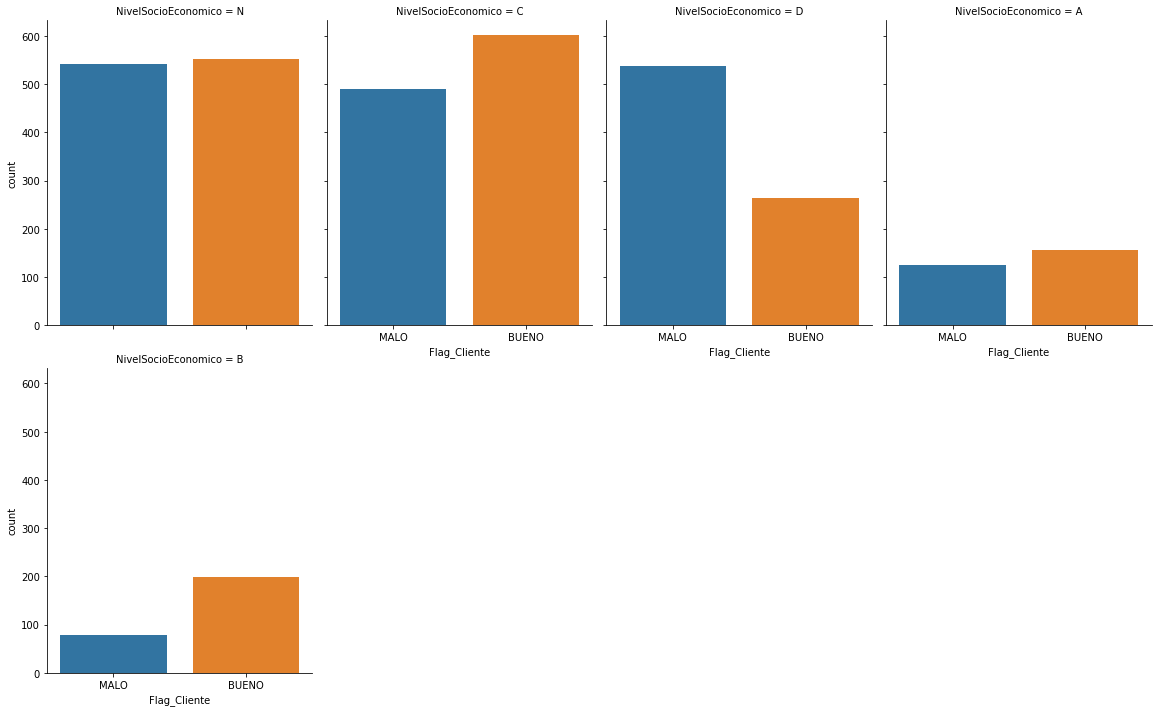

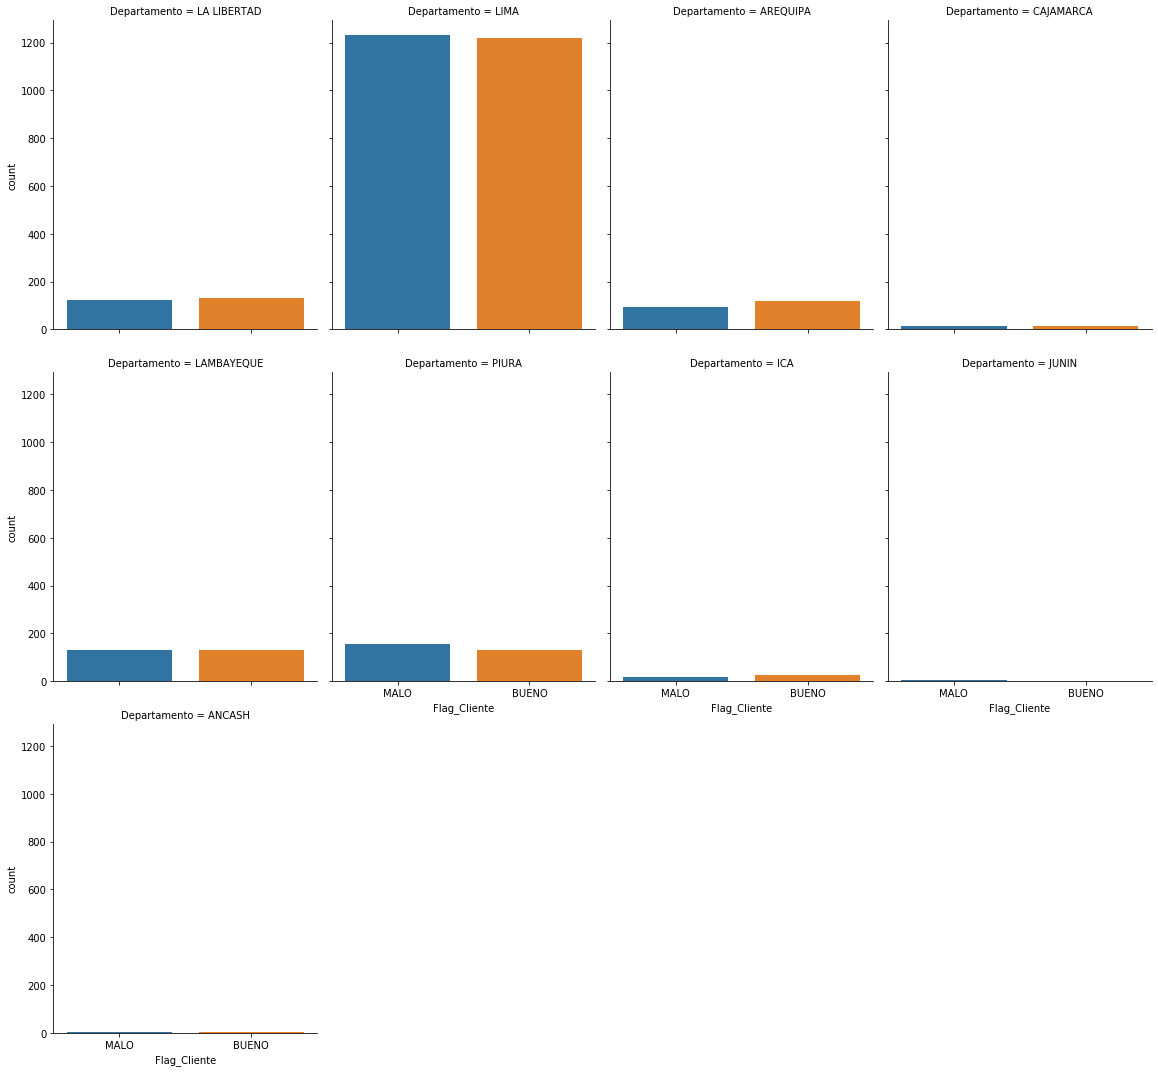

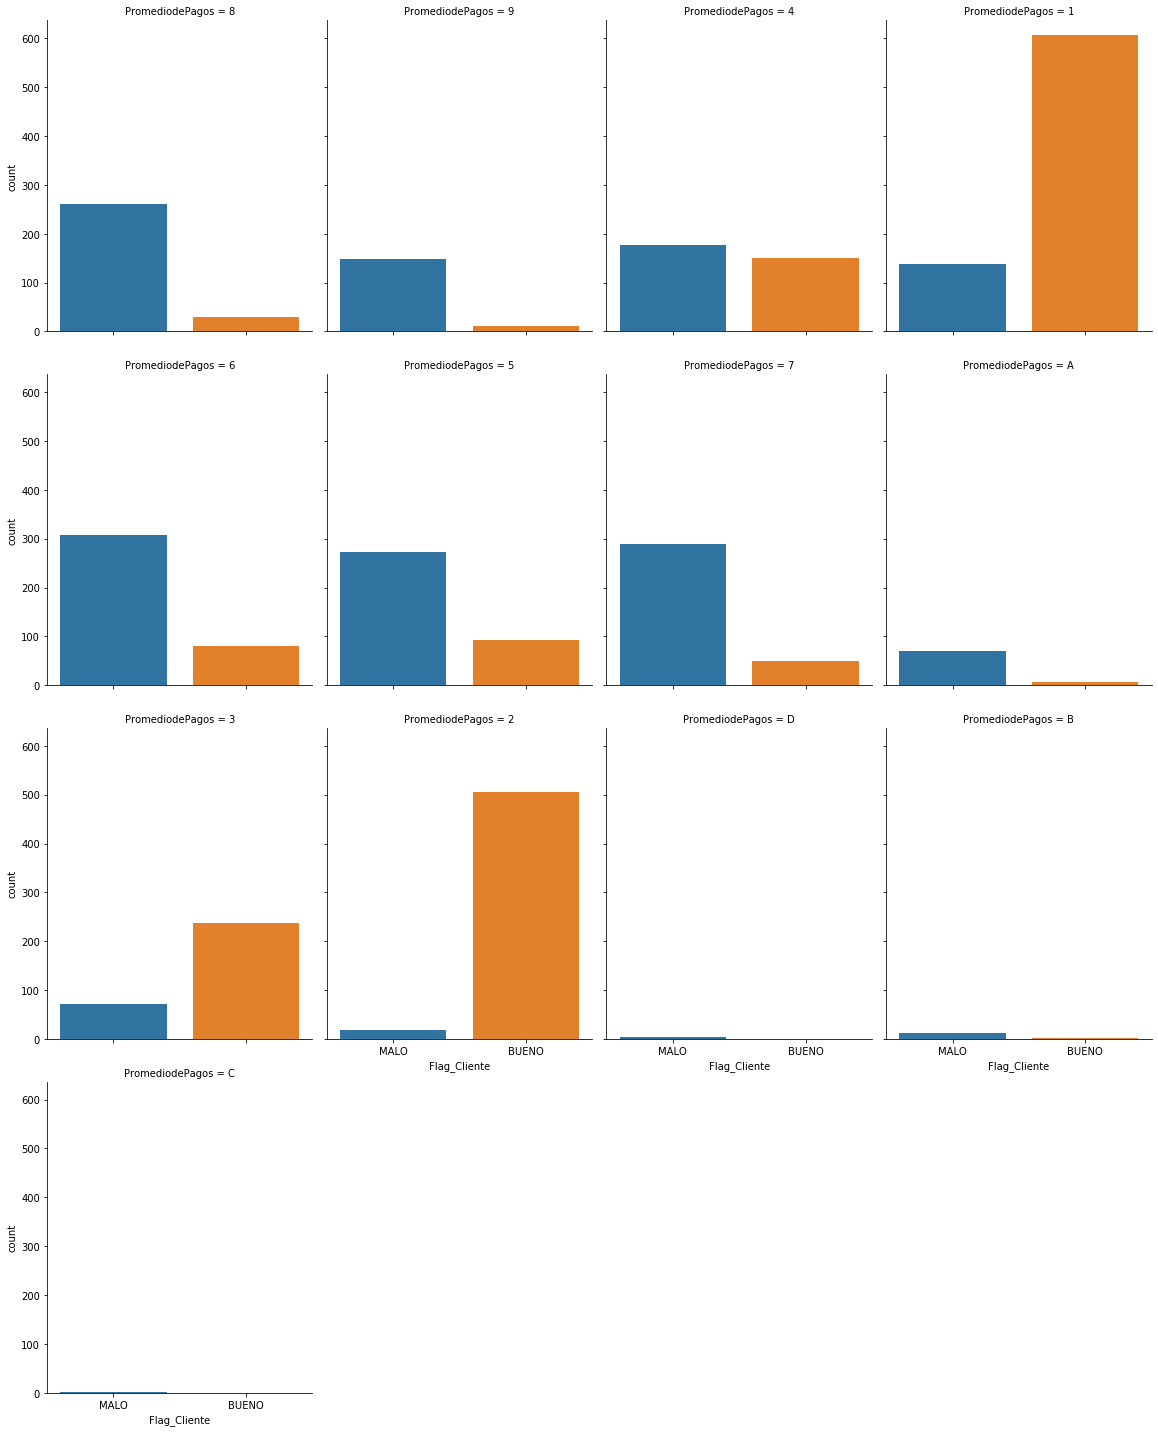

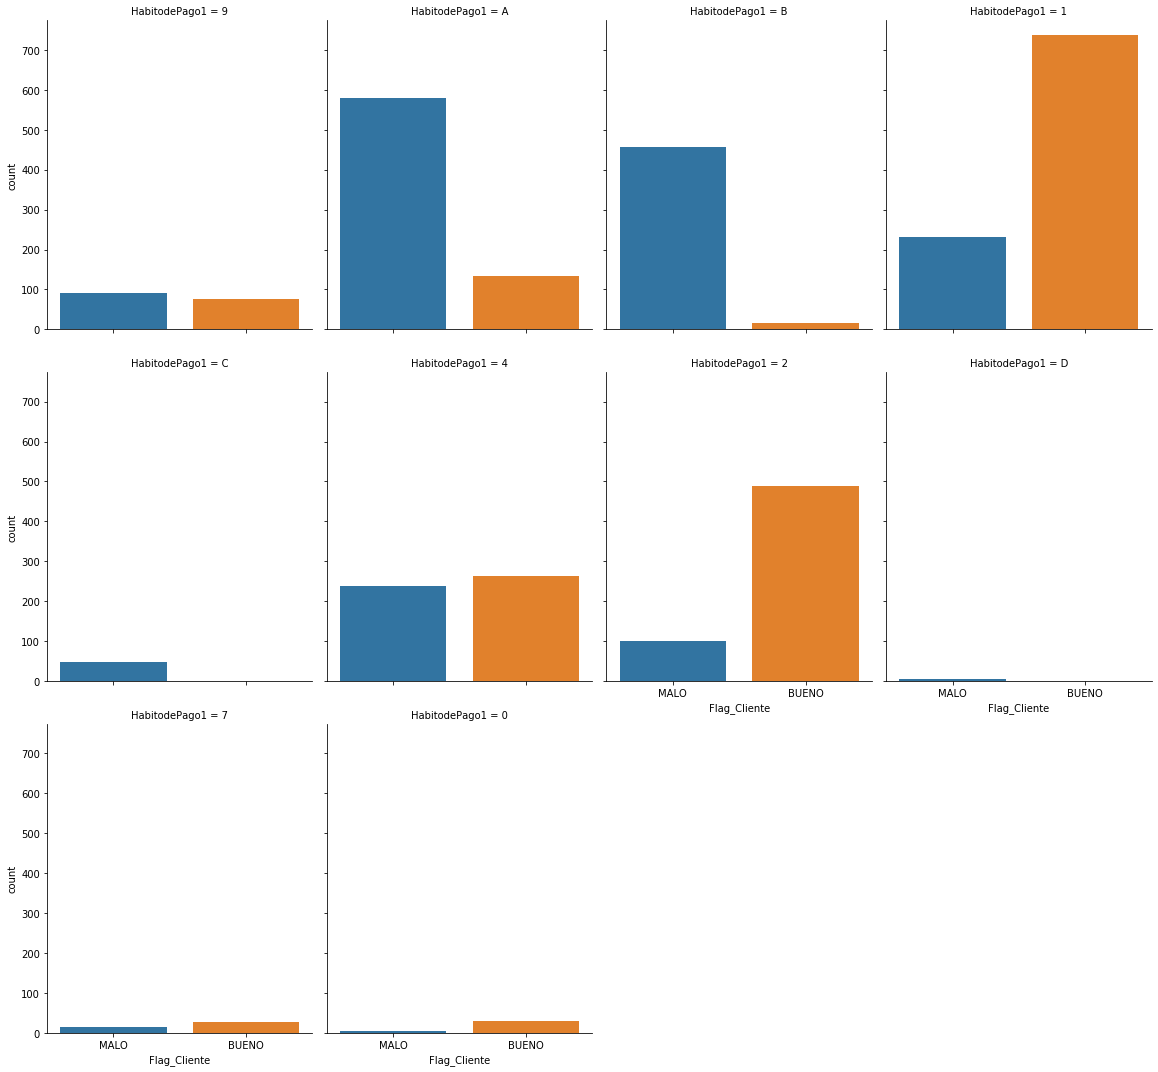

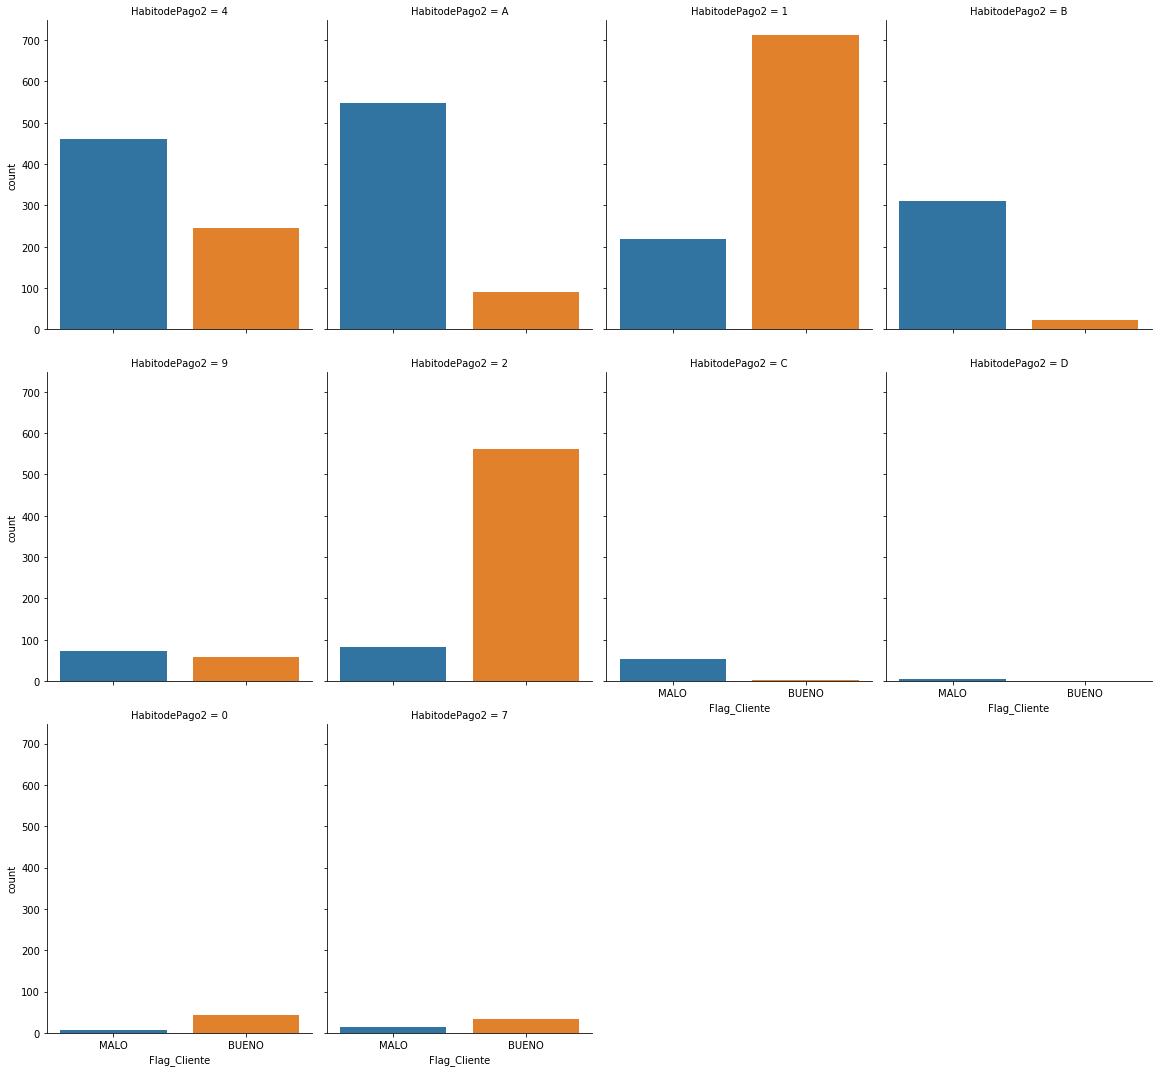

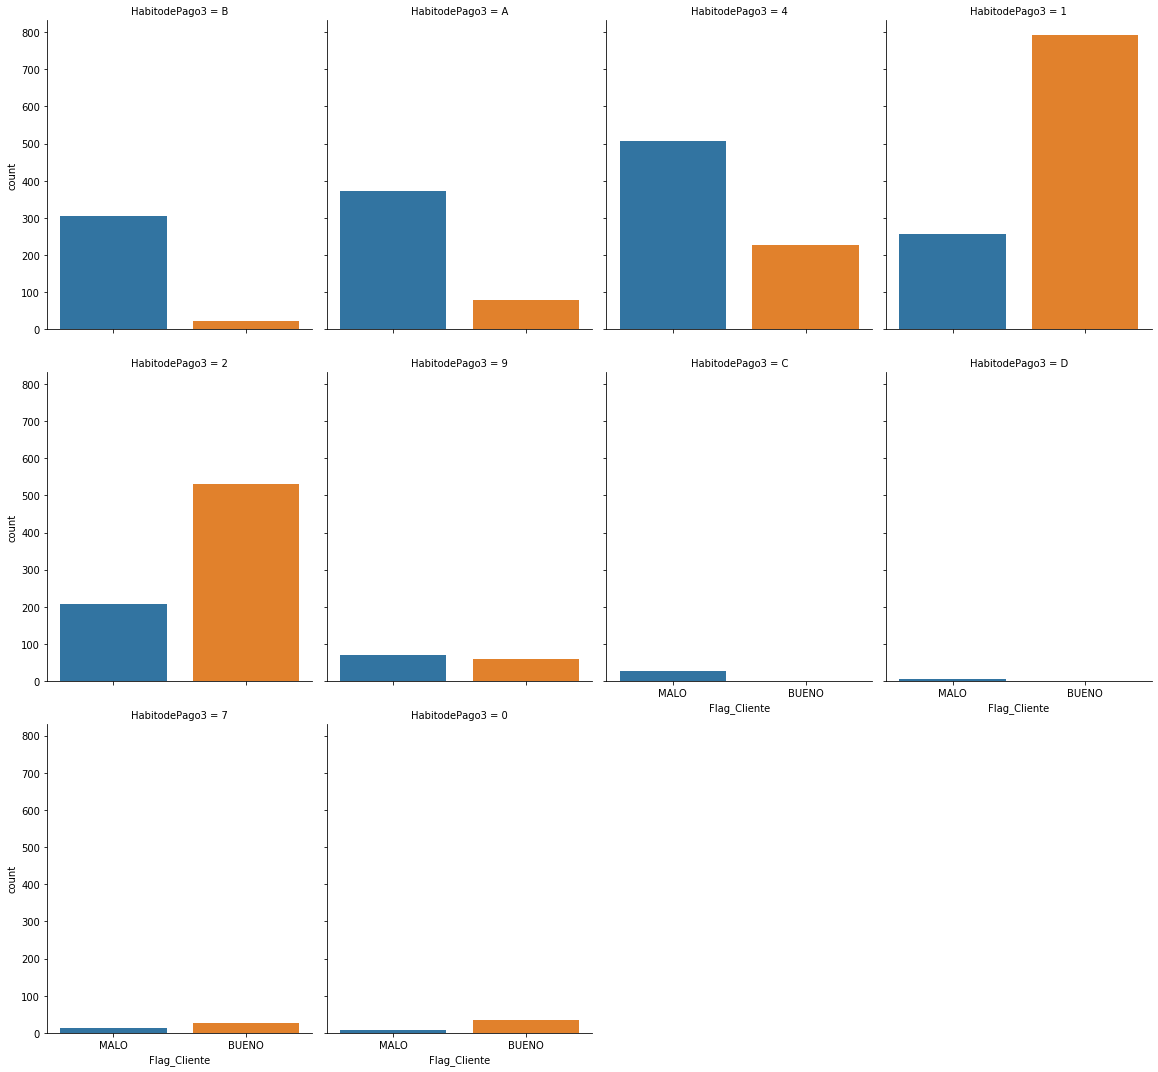

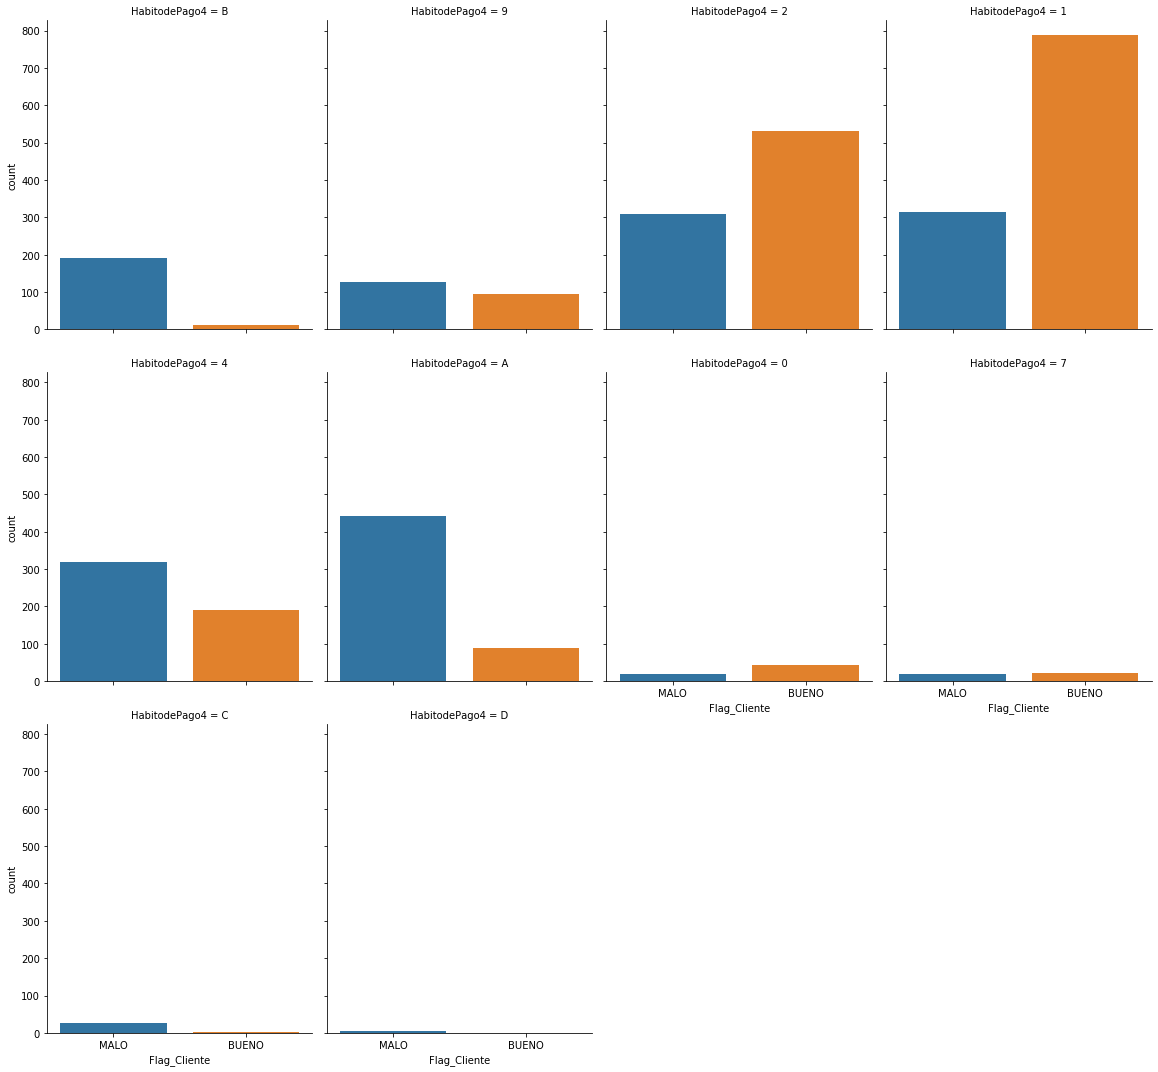

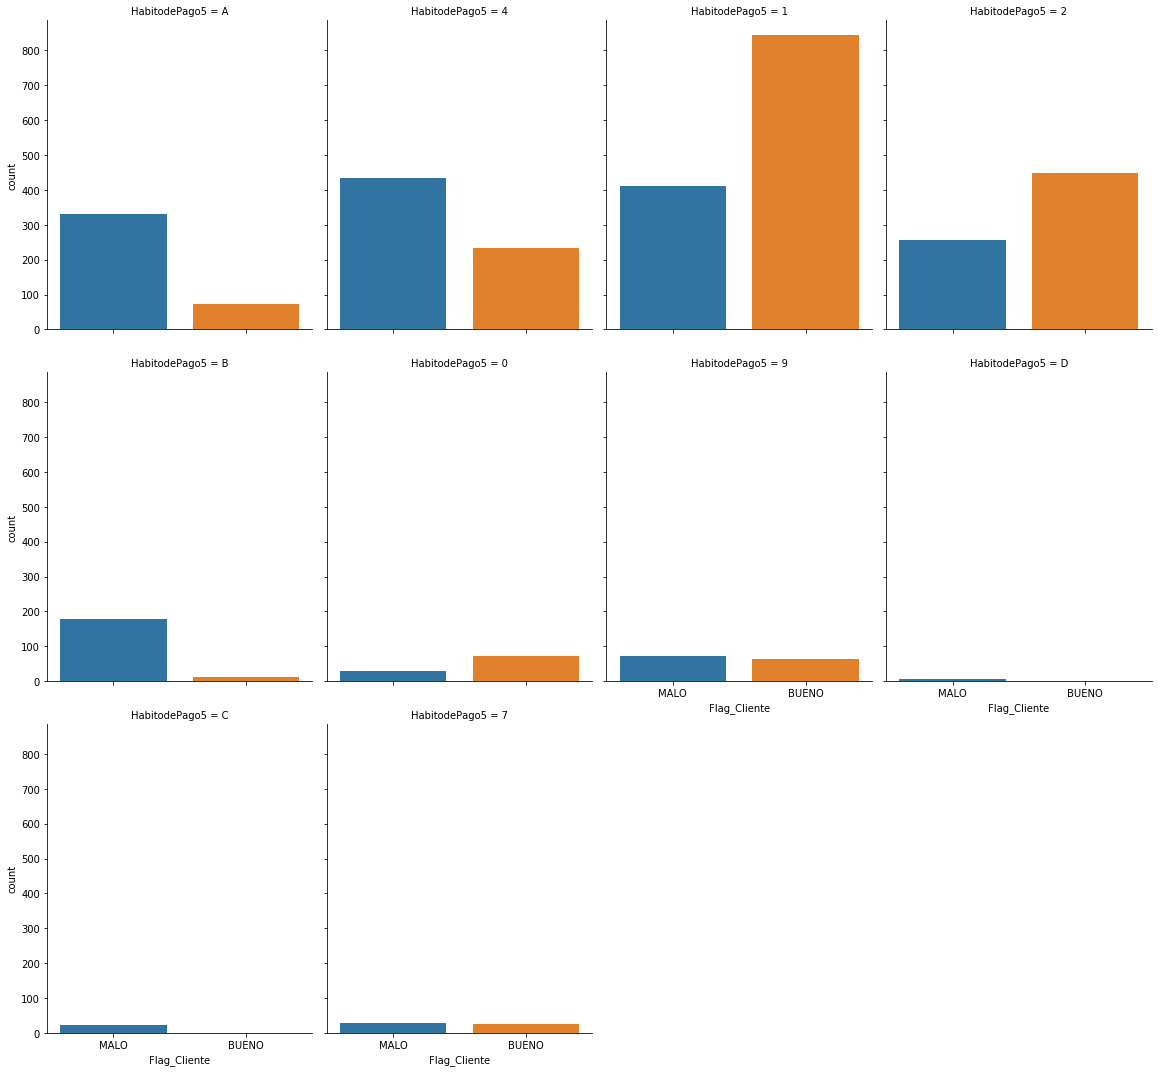

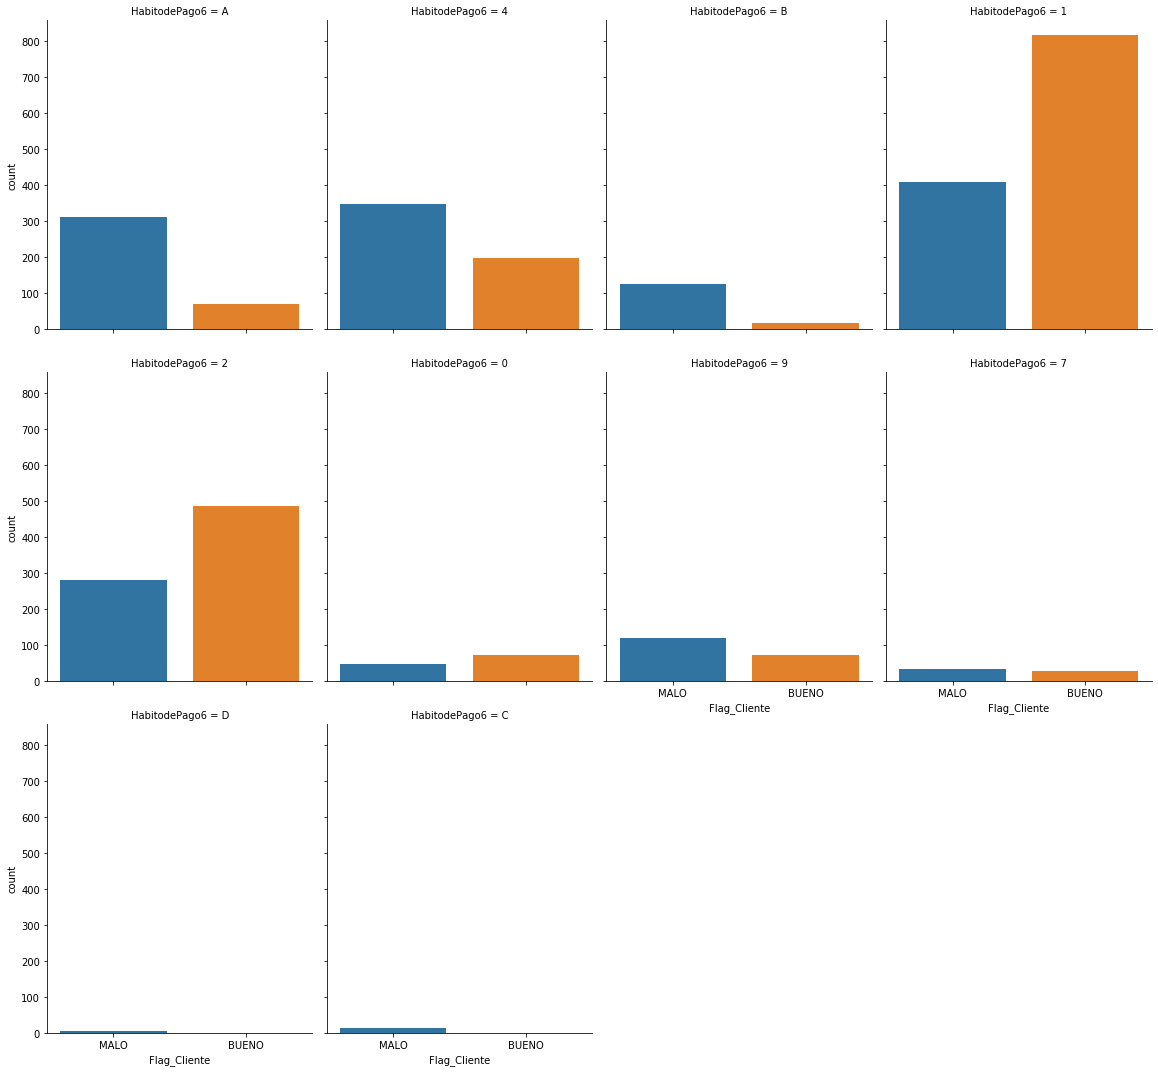

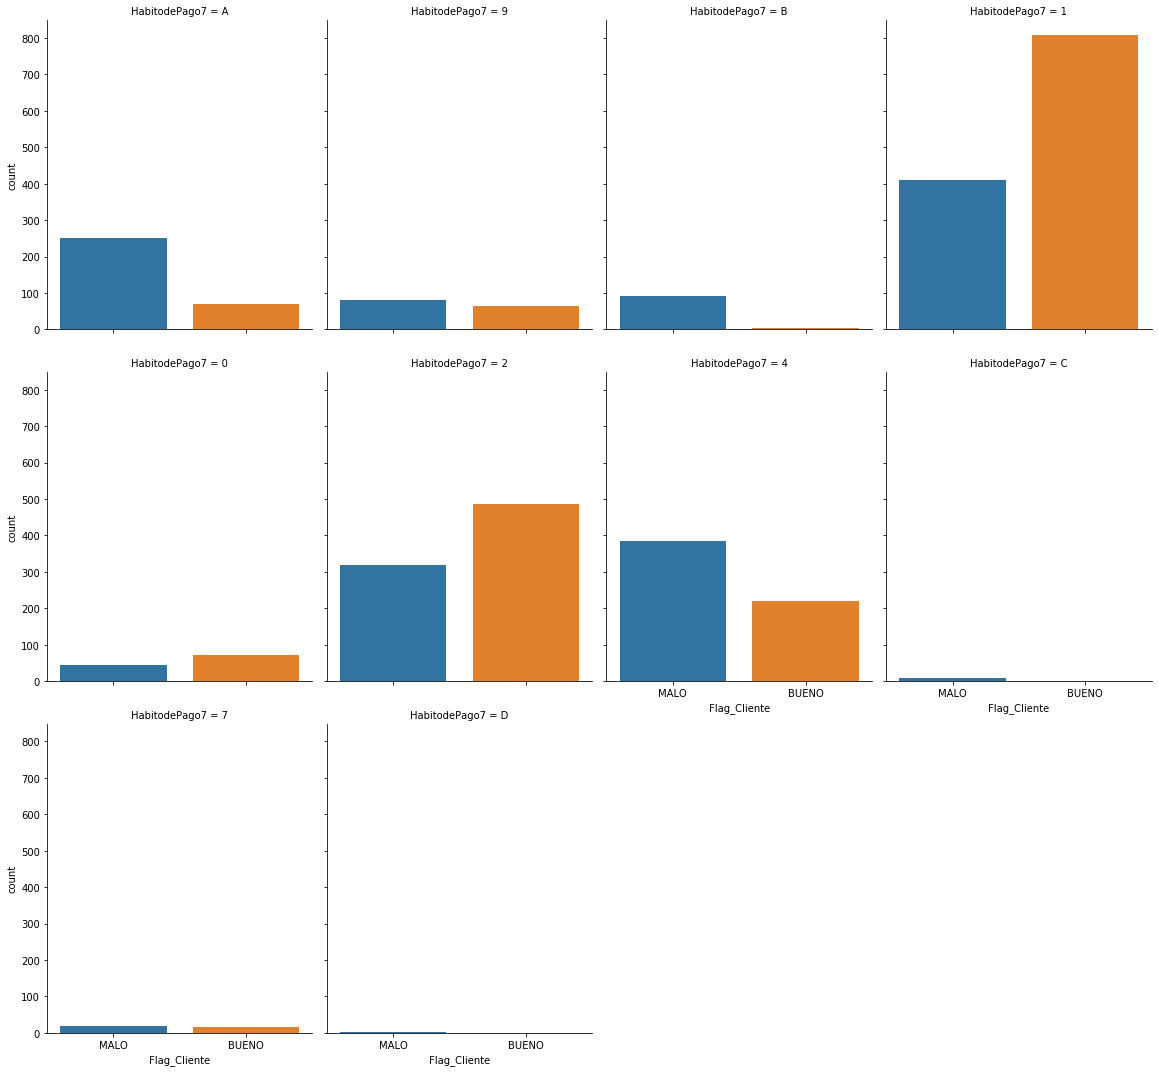

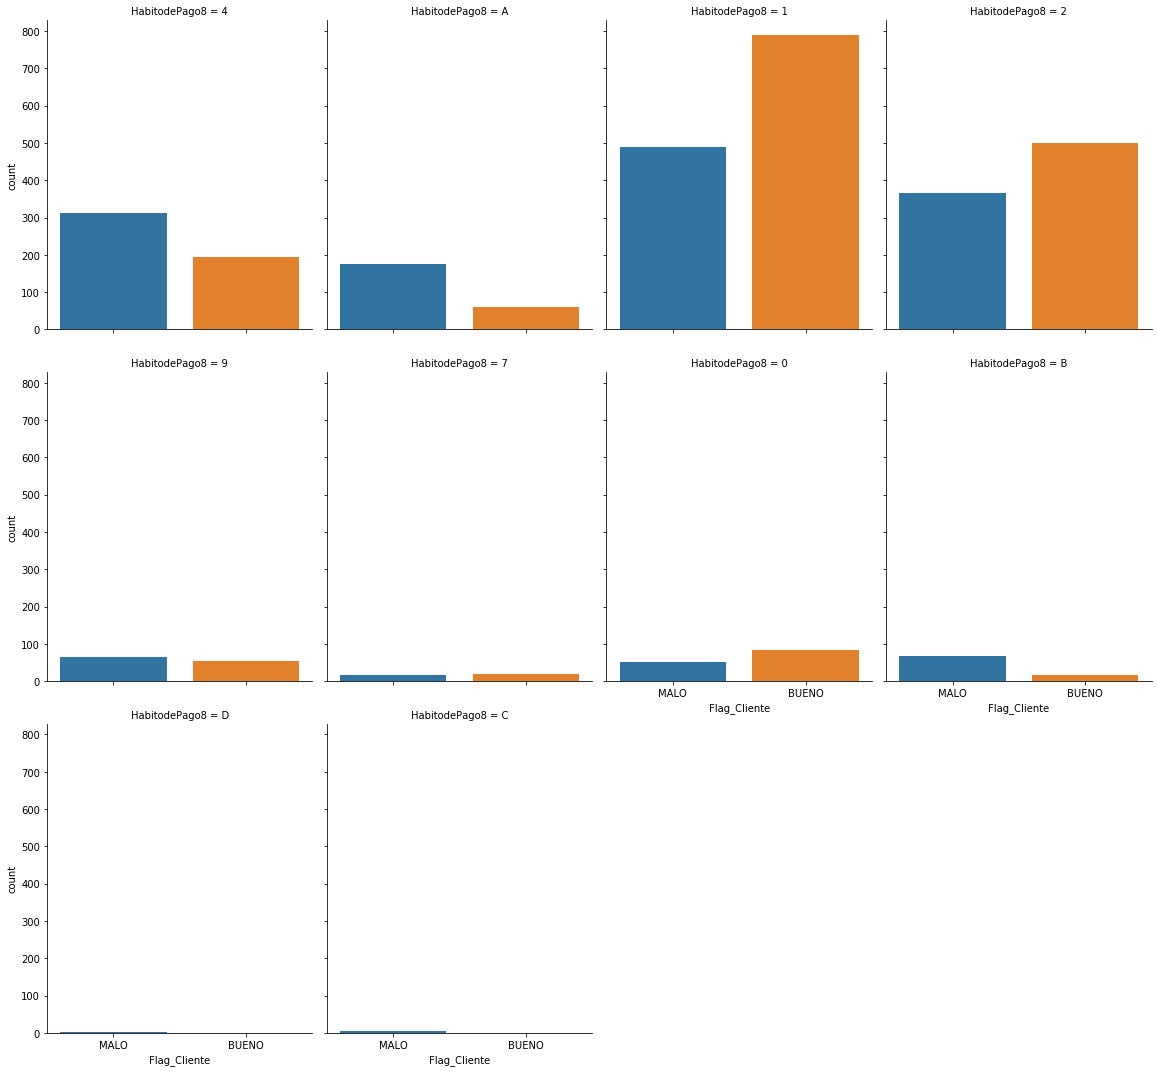

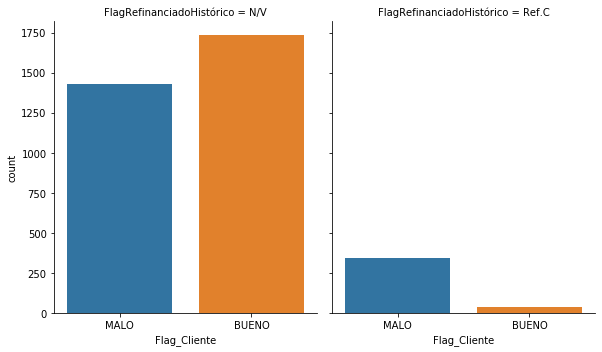

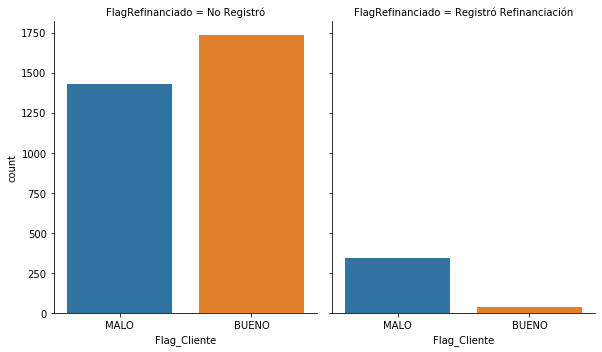

In [28]:
for cat in feature_columns["categorical"]:
  #plt.figure(figsize=(15,8))
  g = sns.catplot("Flag_Cliente", col=cat, col_wrap=4,data=Train_Balanceado,kind="count", height=5, aspect=.8)
  plt.show()
  import gc
  gc.collect()

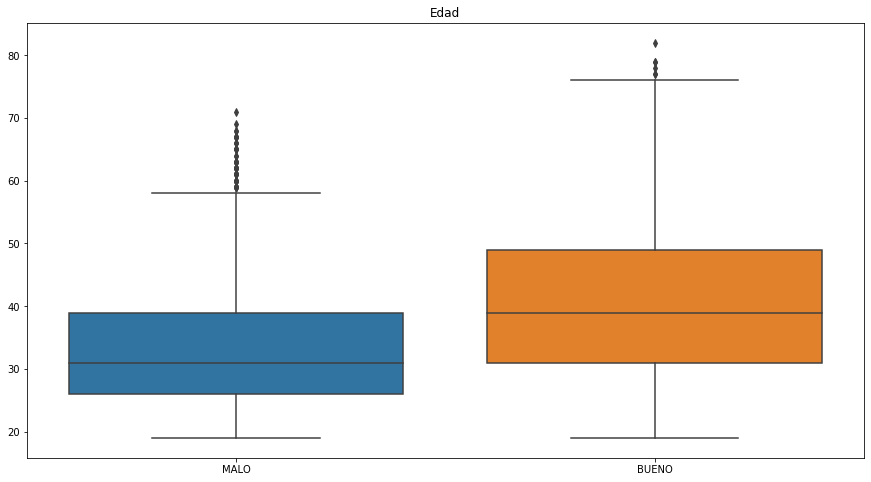

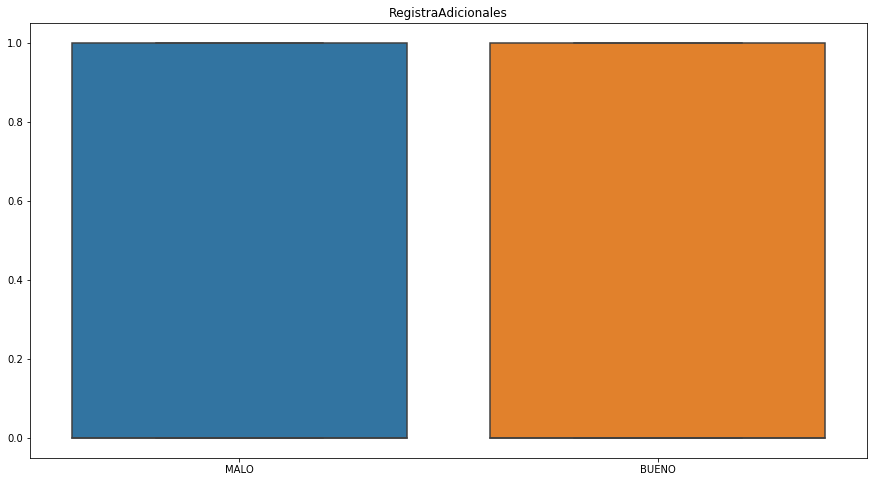

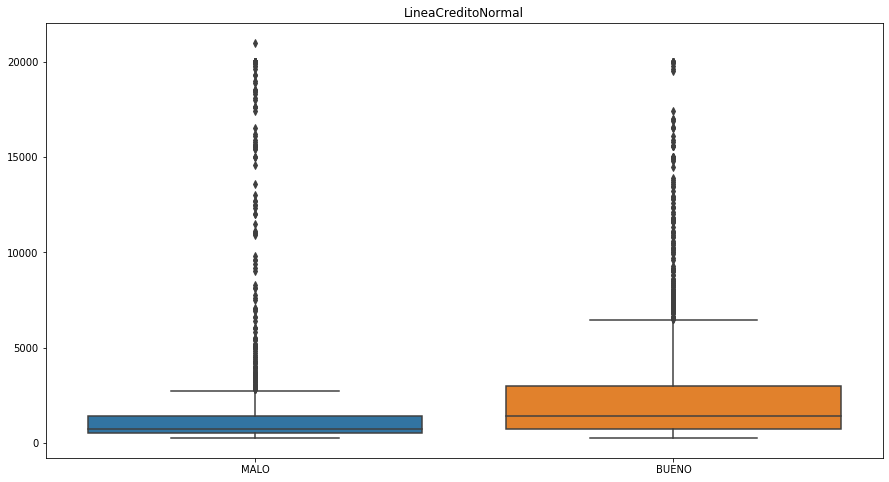

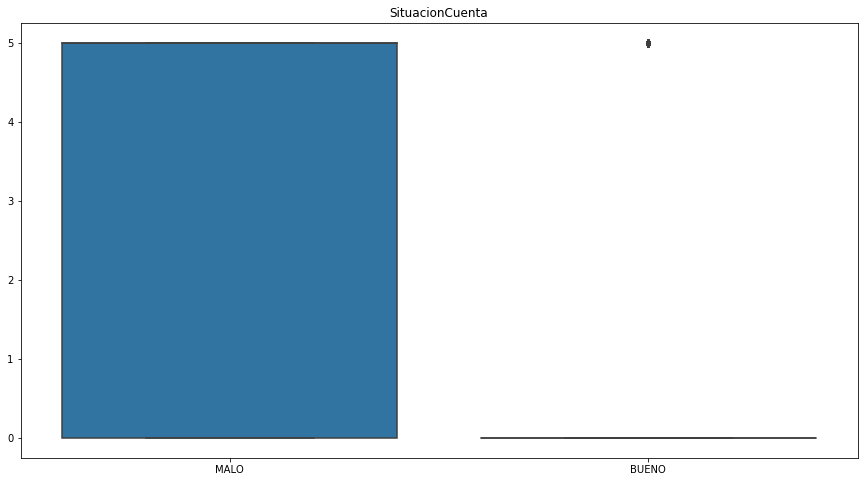

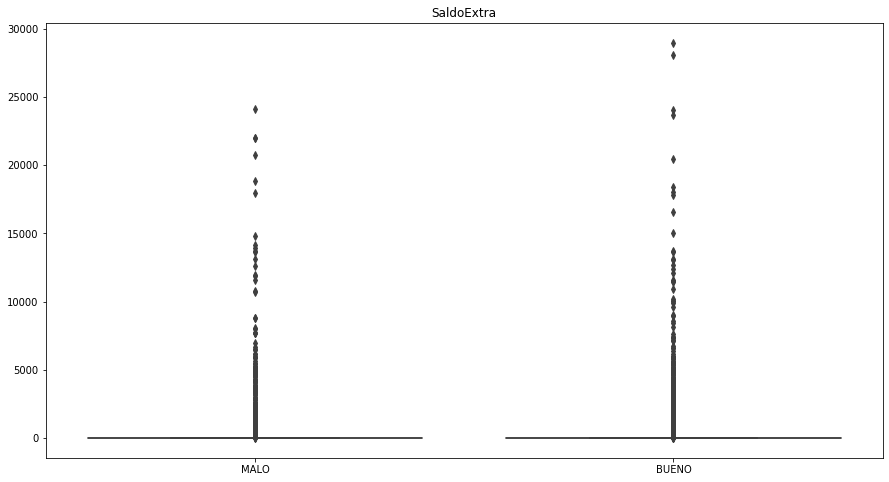

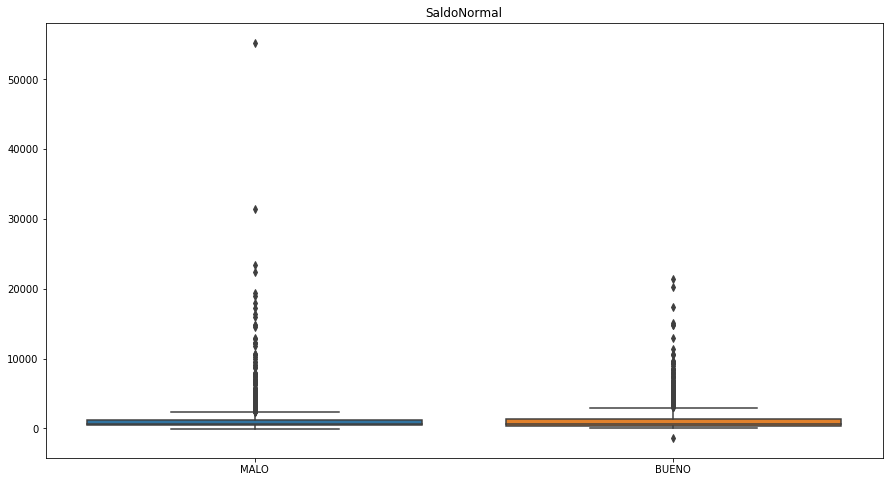

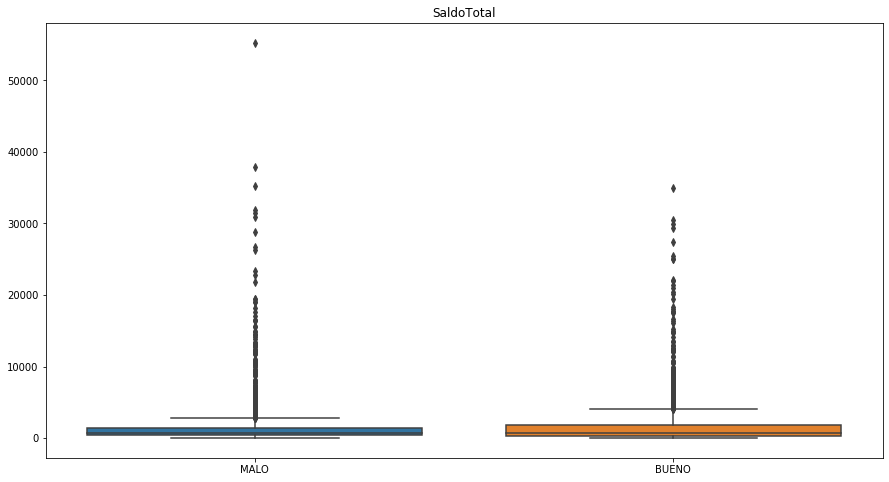

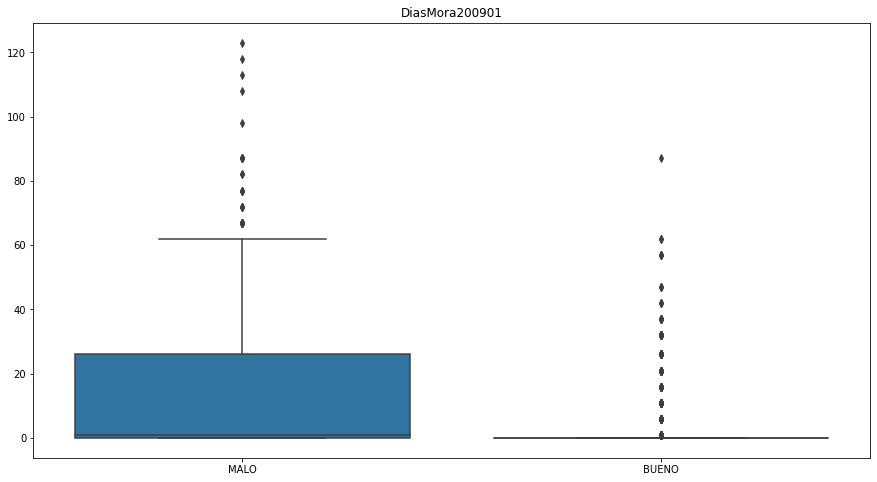

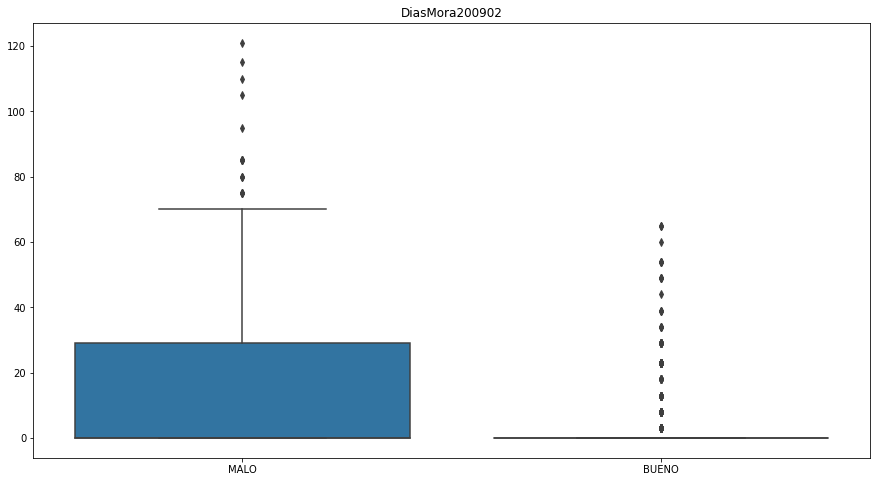

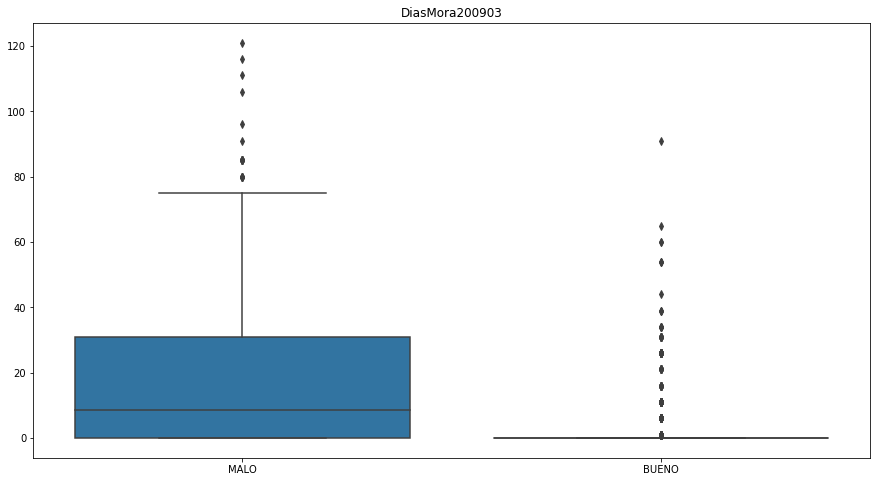

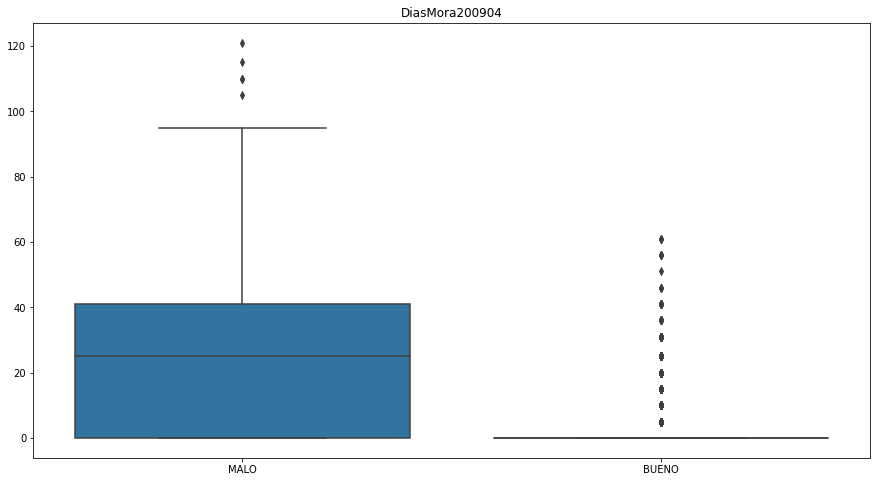

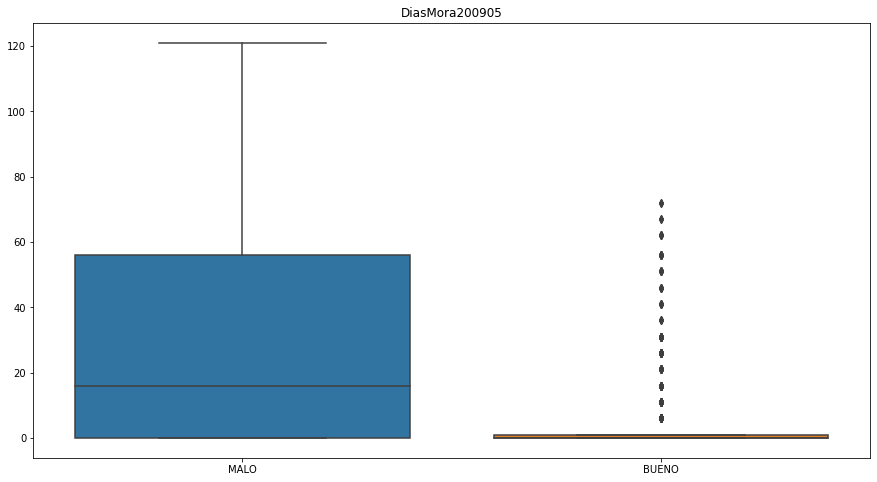

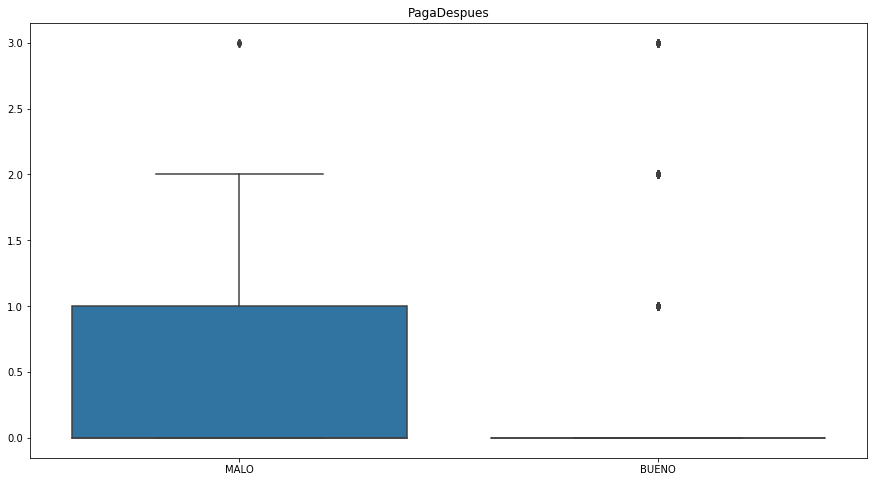

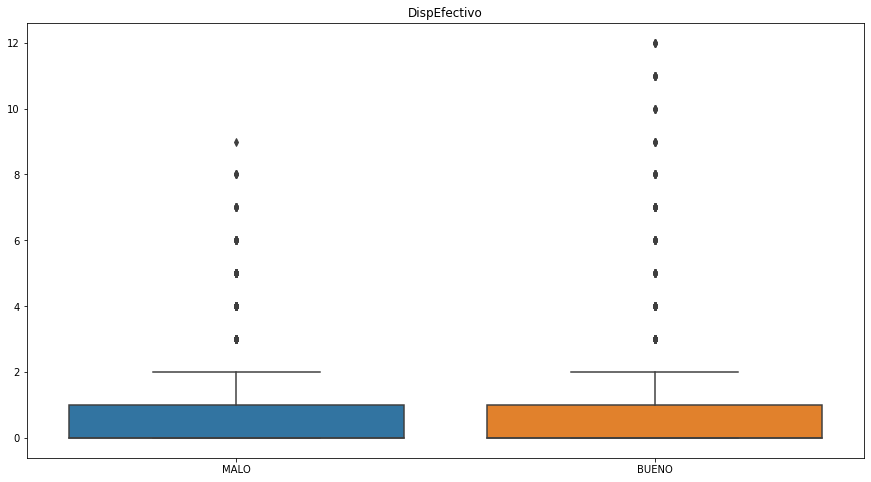

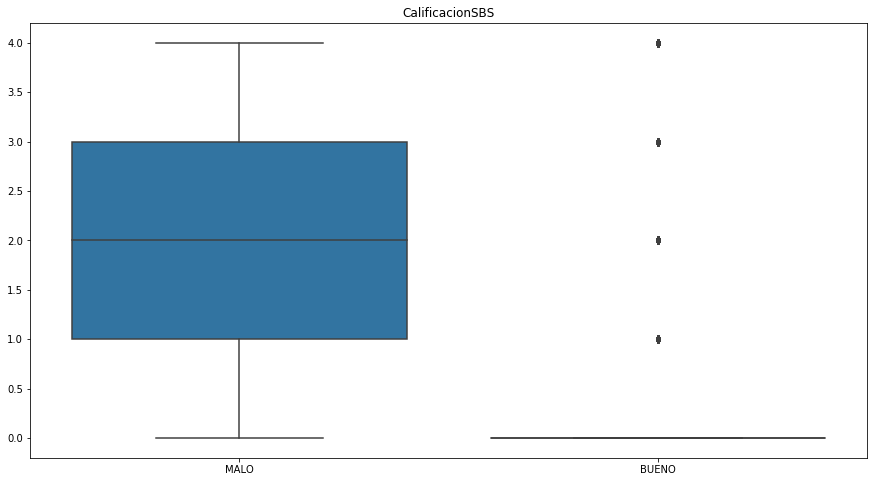

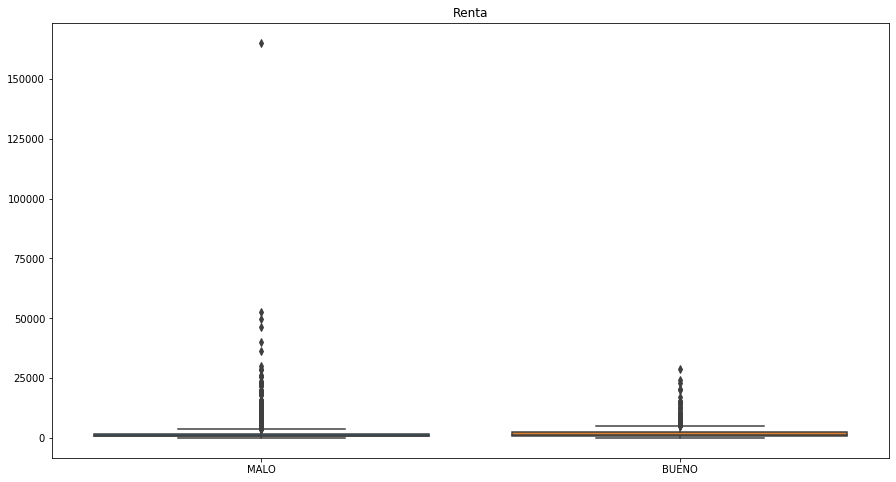

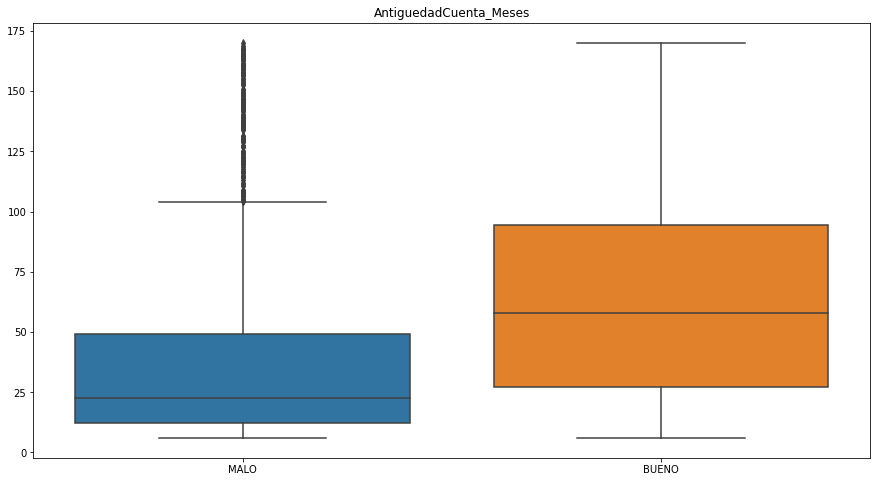

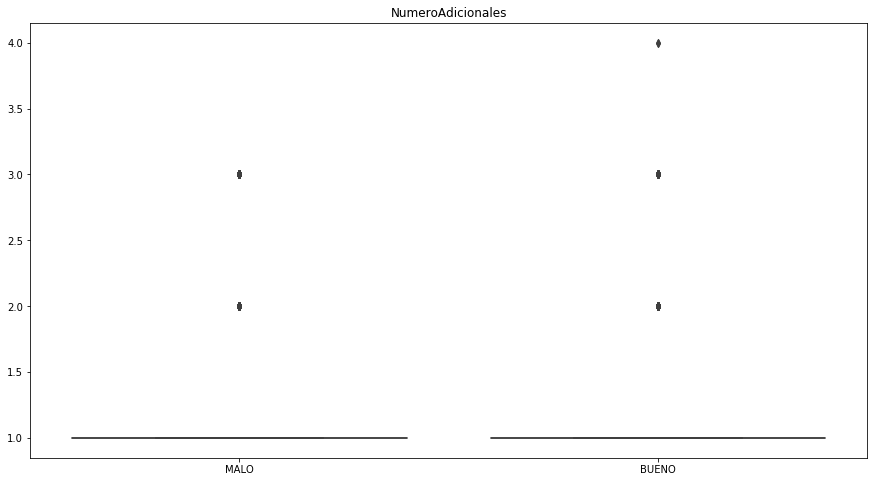

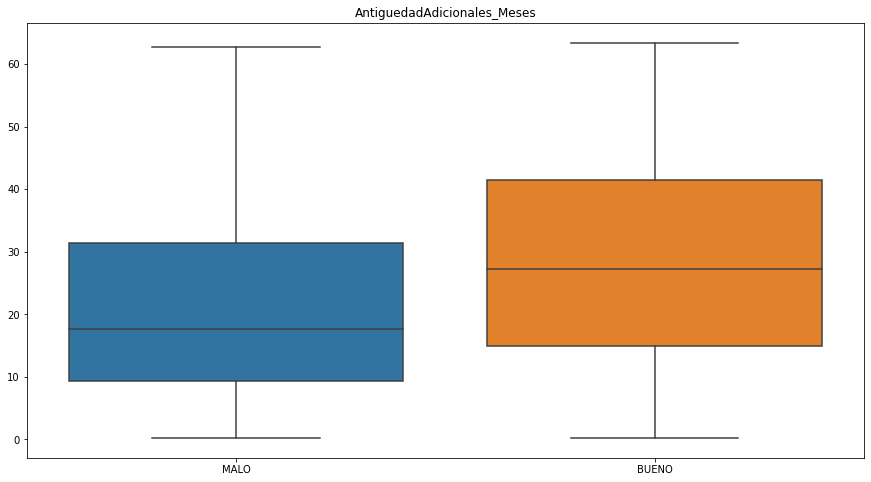

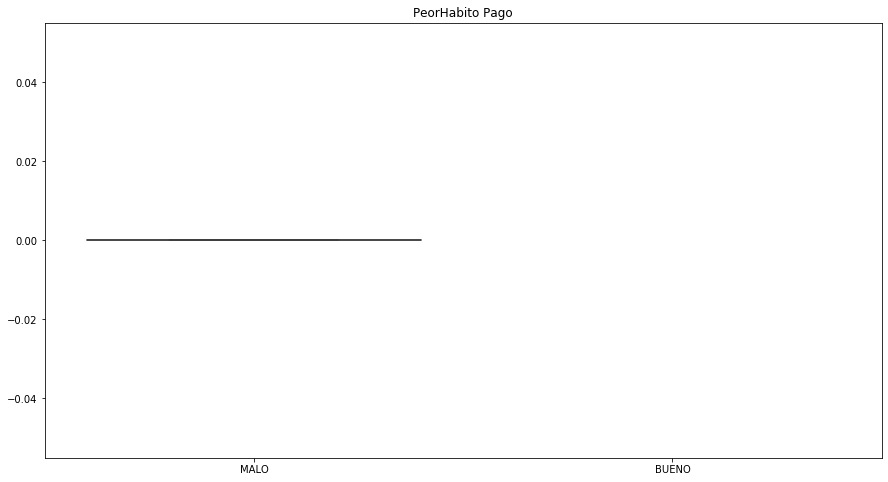

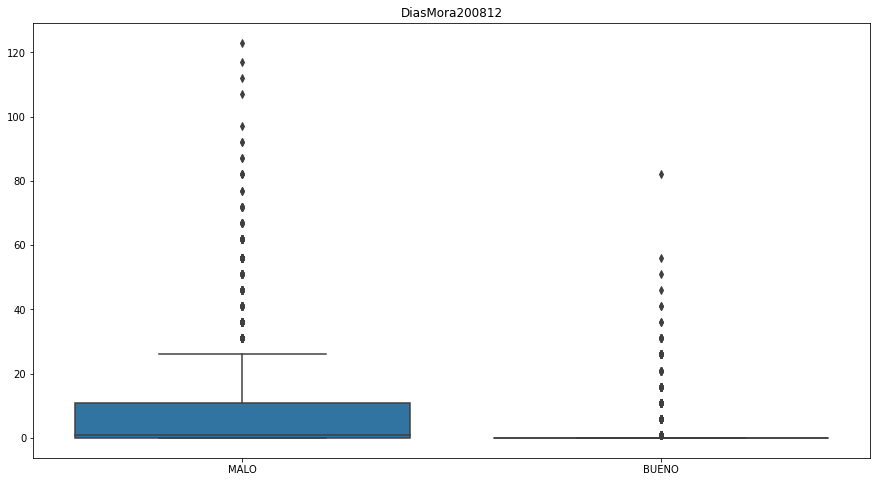

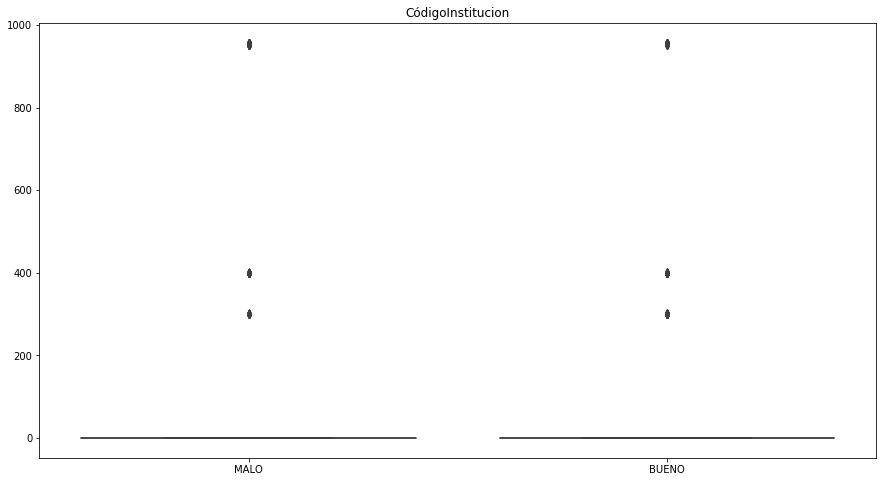

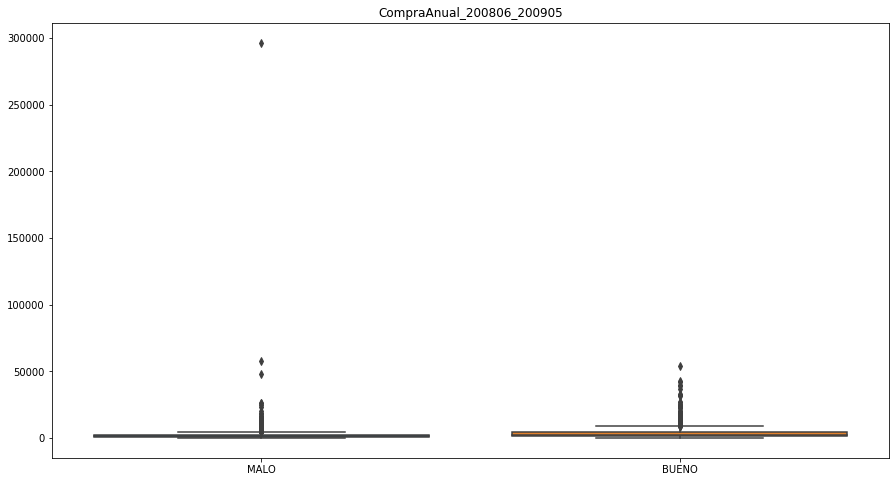

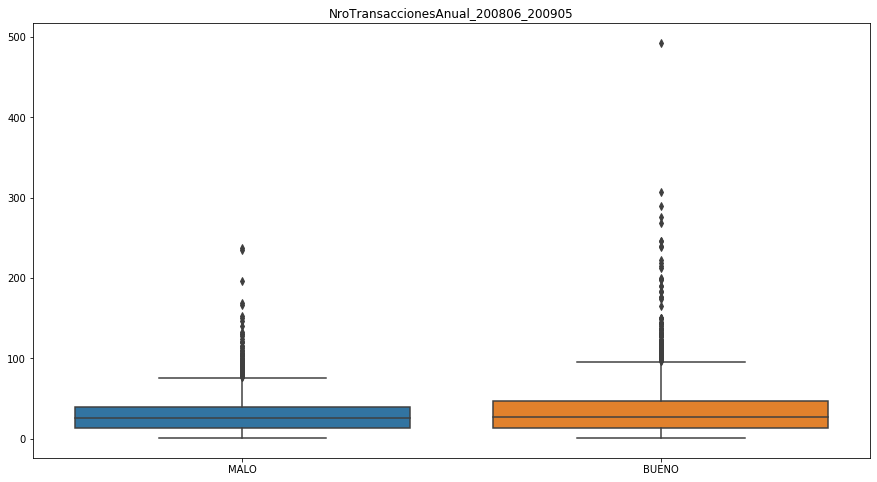

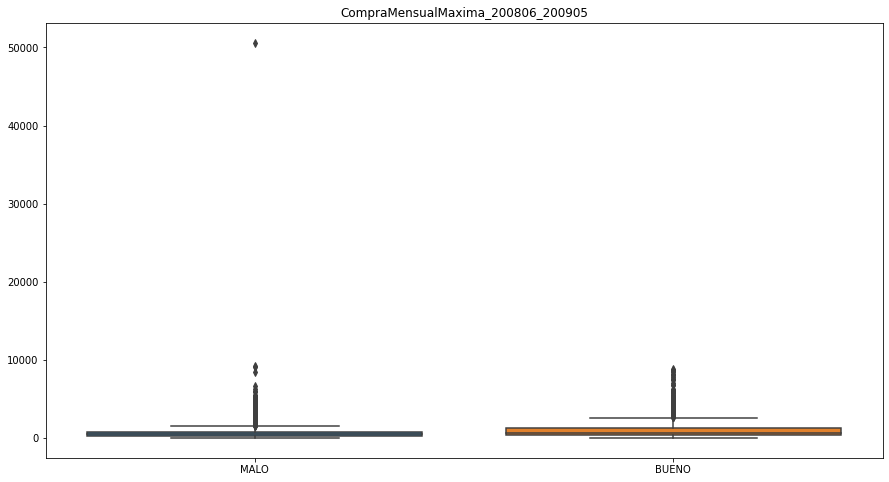

In [29]:
for cat in feature_columns["numerical"]:
  
  plt.figure(figsize=(15,8))
  
  
  x=pd.concat([Train_Balanceado.loc[Train_Balanceado["Flag_Cliente"]=="MALO",cat],
          Train_Balanceado.loc[Train_Balanceado["Flag_Cliente"]=="BUENO",cat]],axis=1)
  x.columns=["MALO","BUENO"]
  sns.boxplot(data=x )
  plt.title(cat)
  plt.show()
  import gc
  gc.collect()


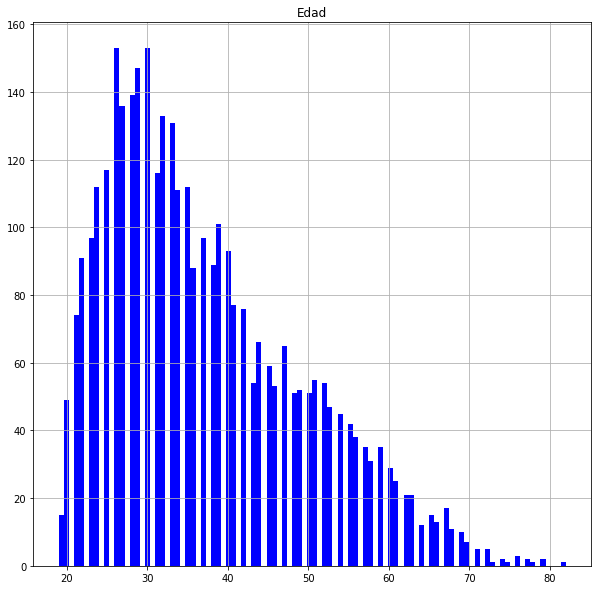

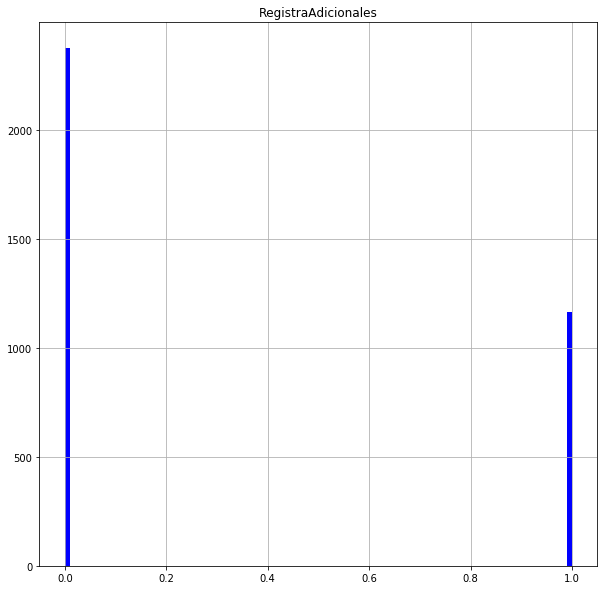

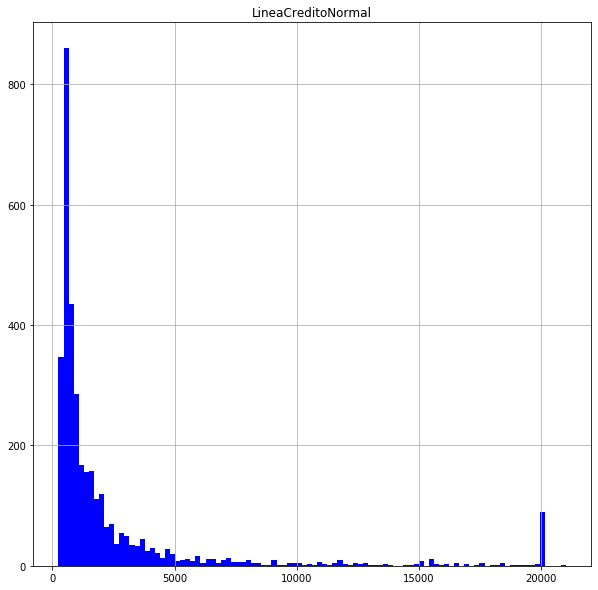

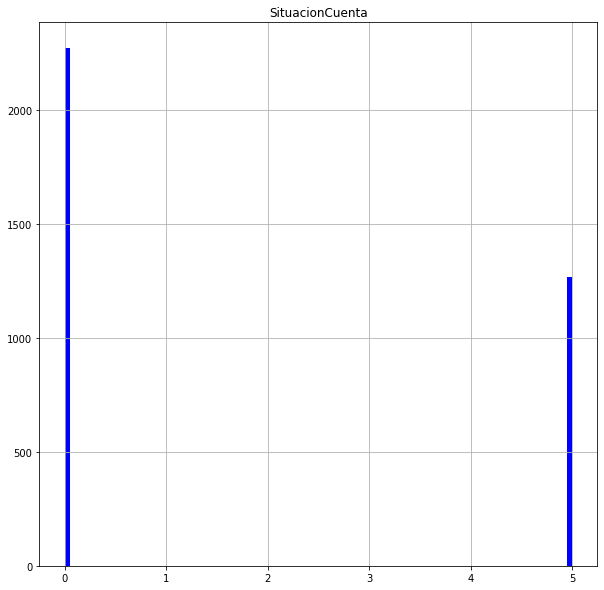

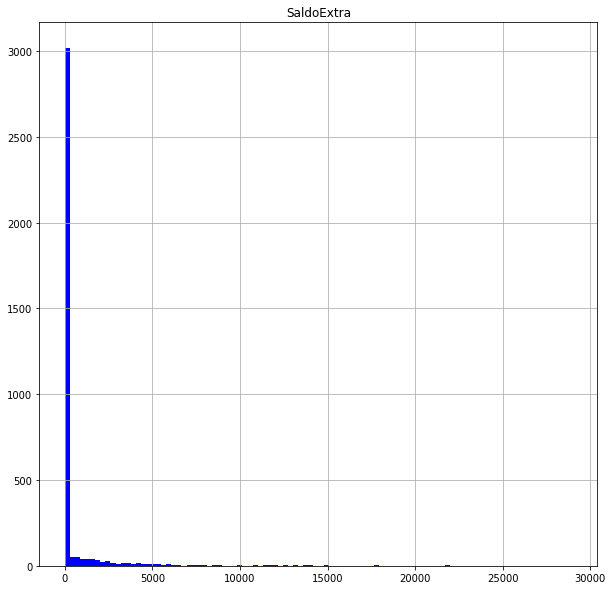

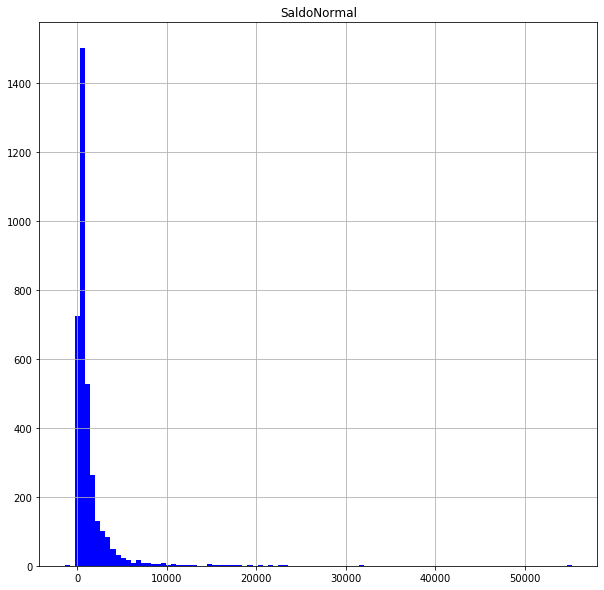

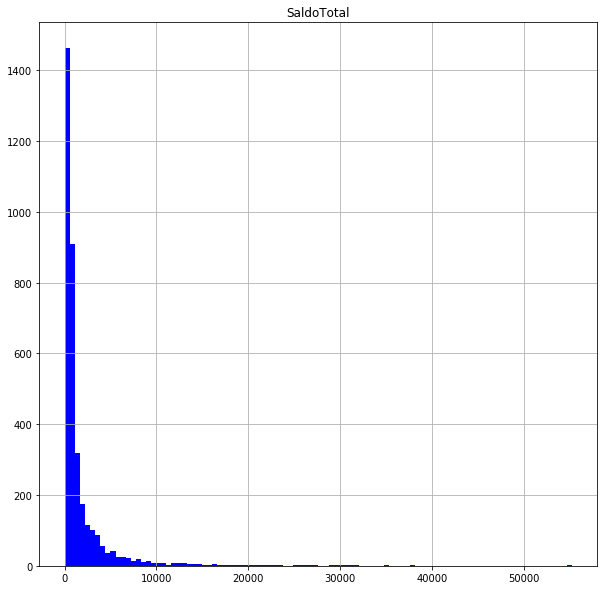

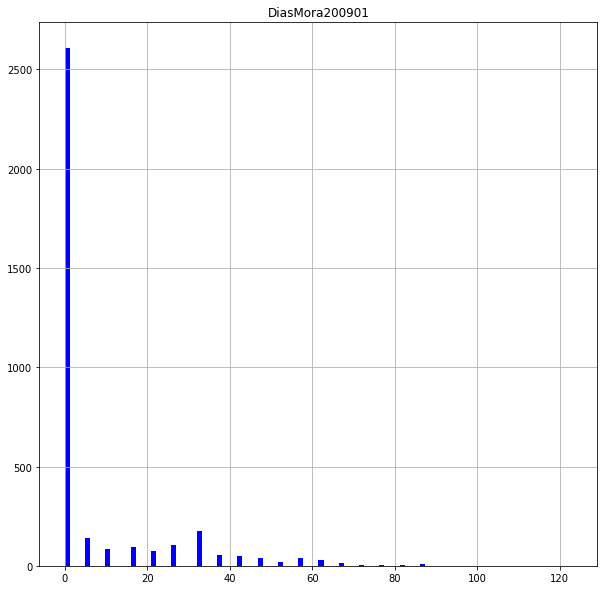

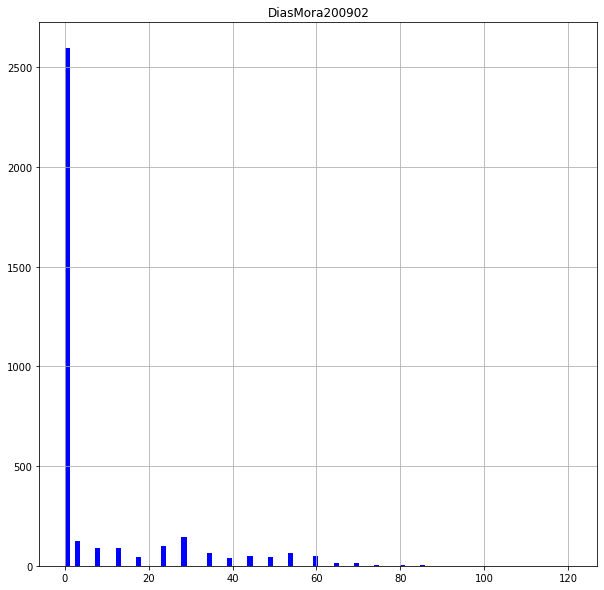

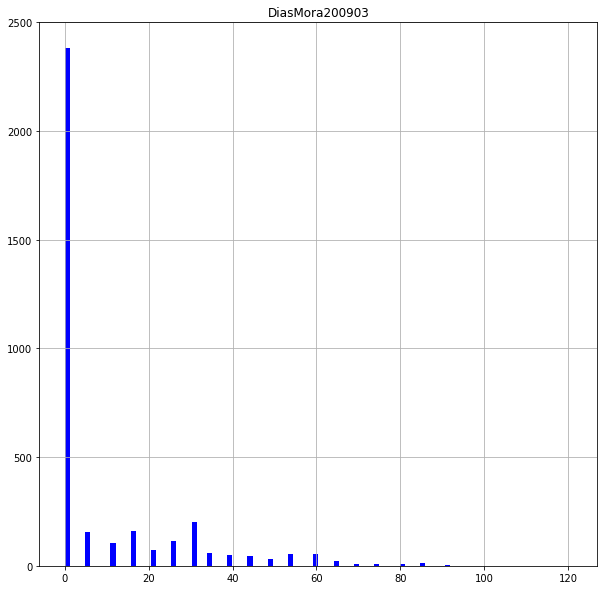

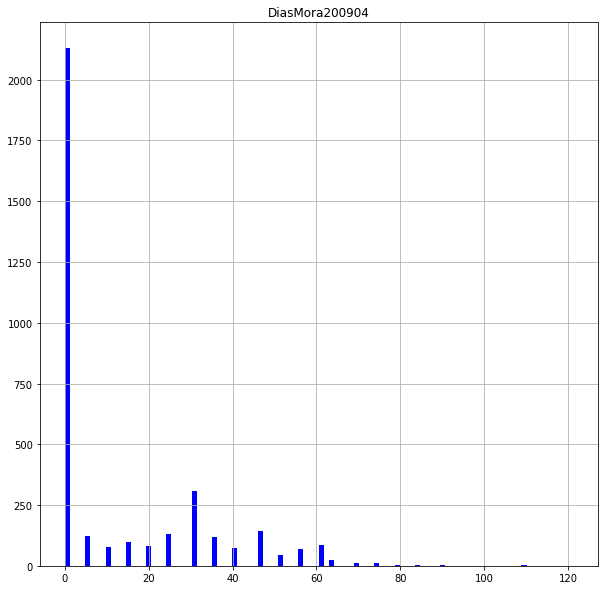

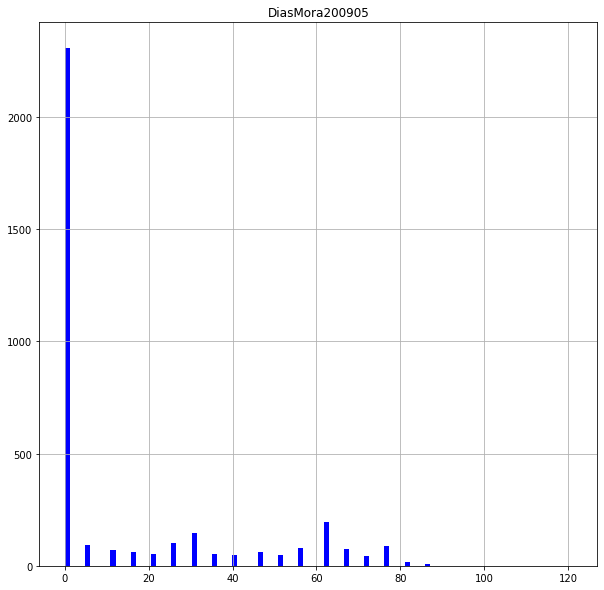

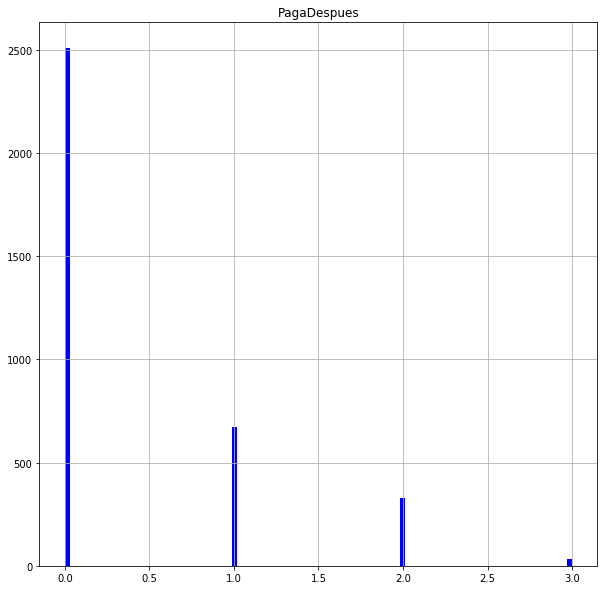

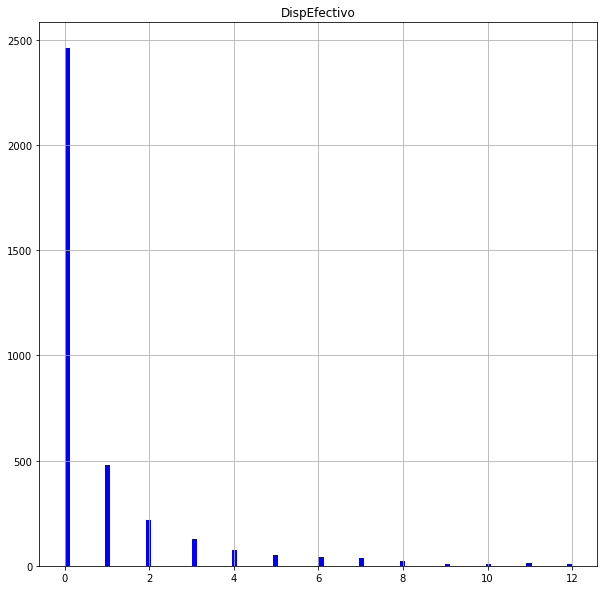

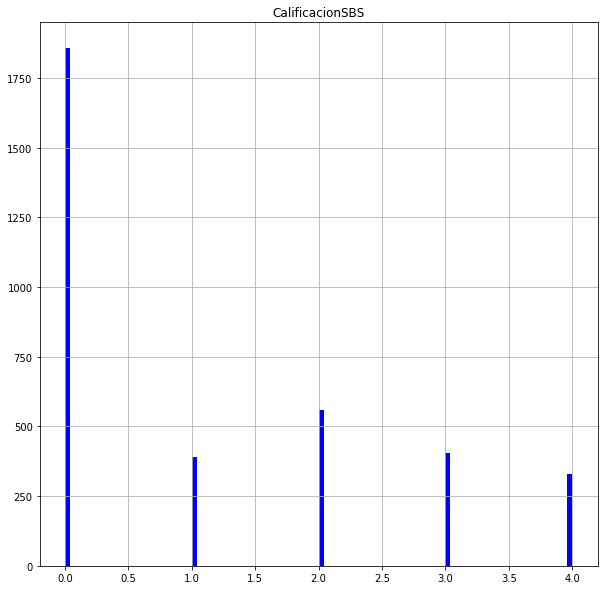

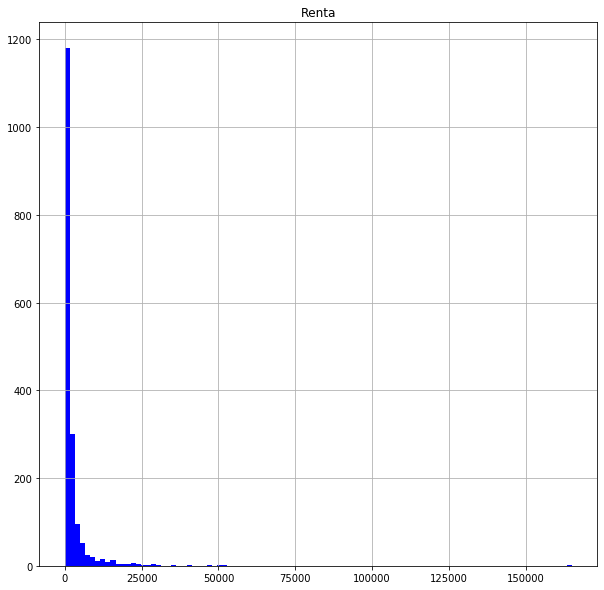

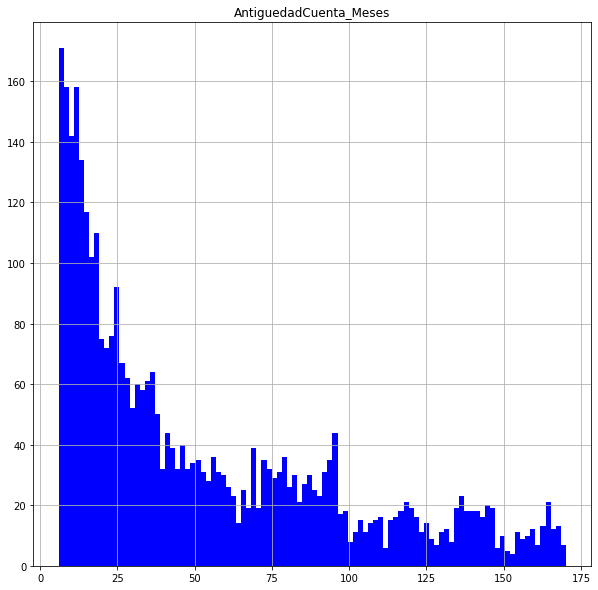

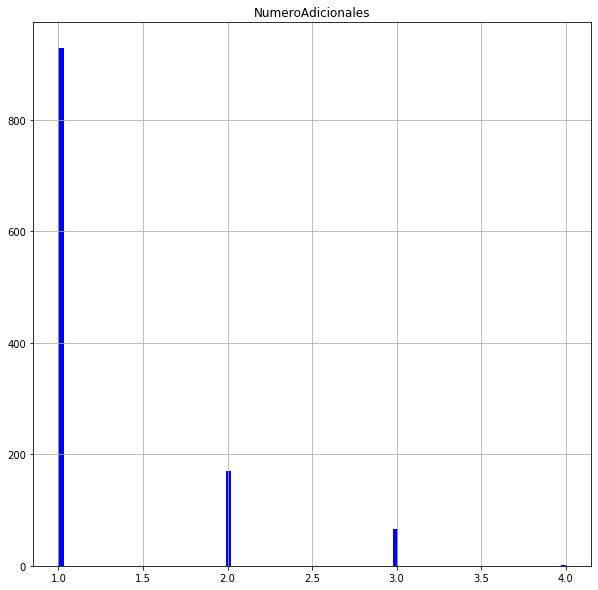

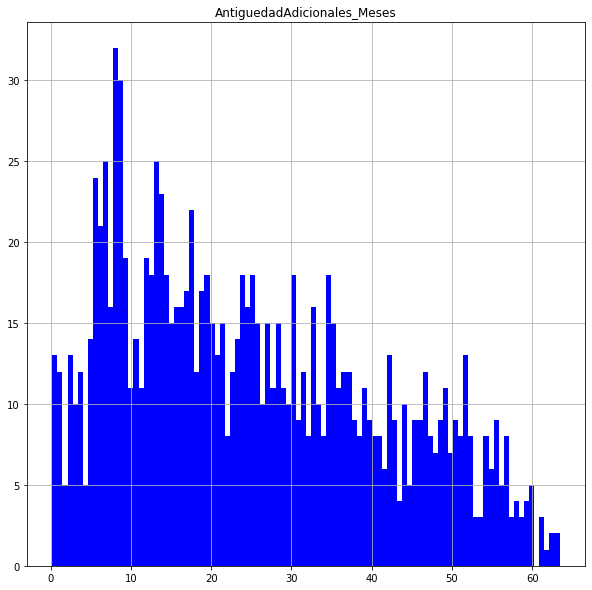

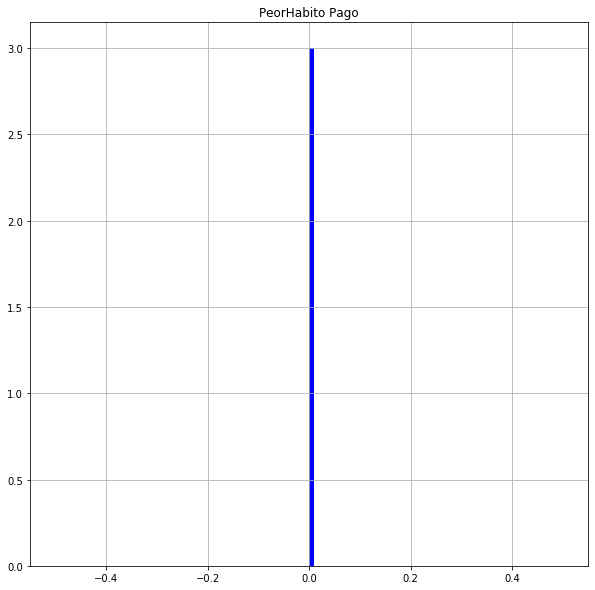

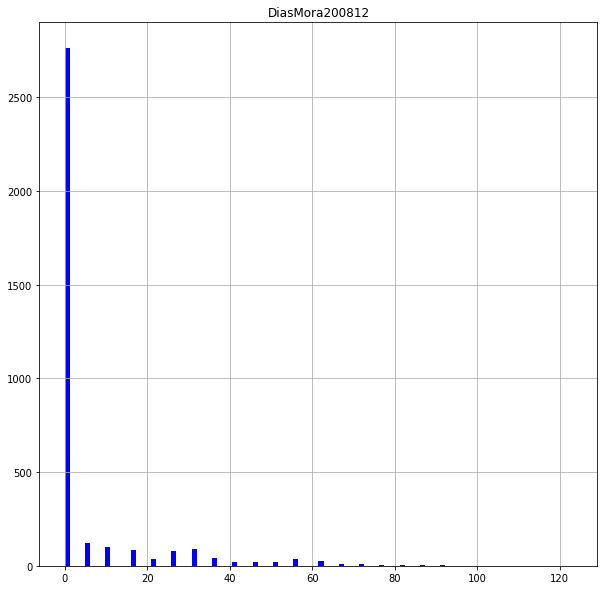

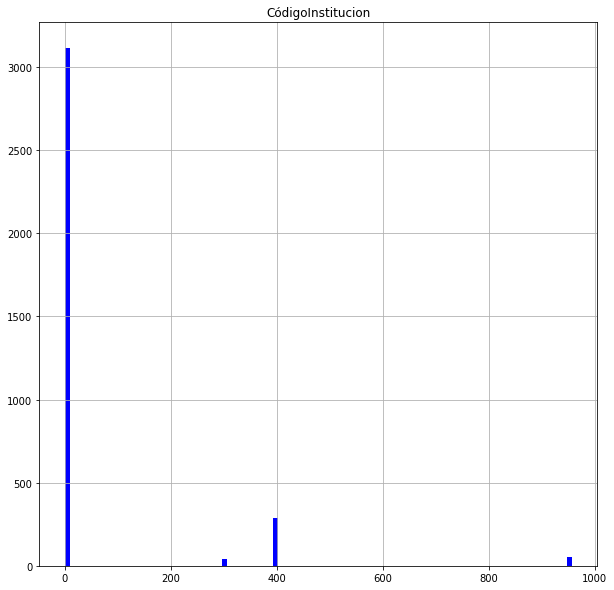

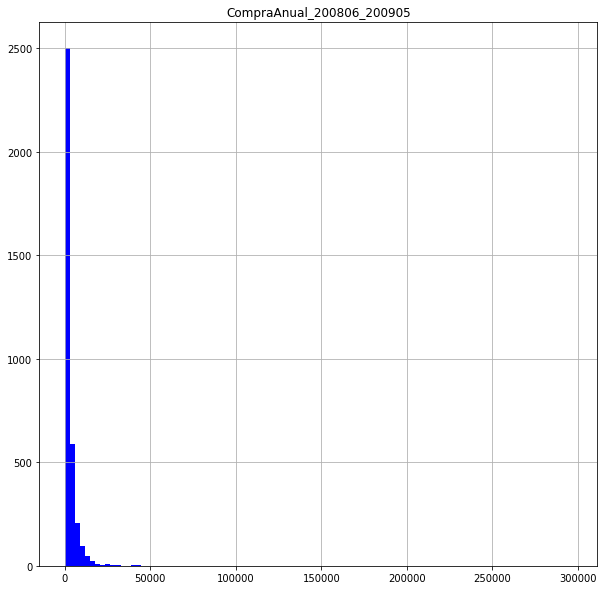

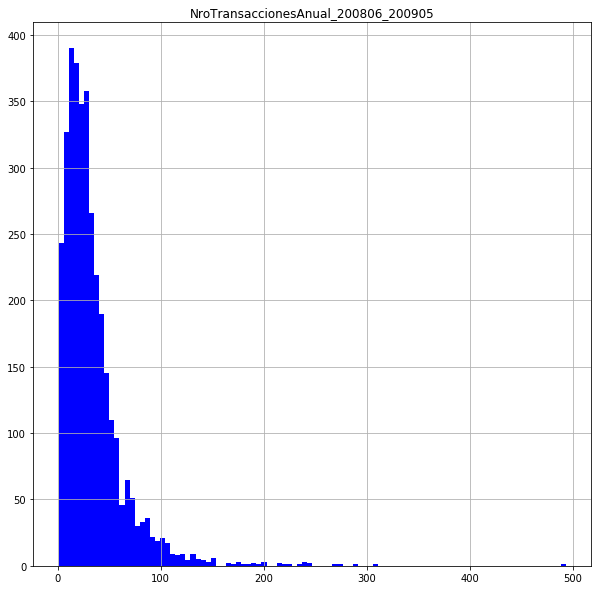

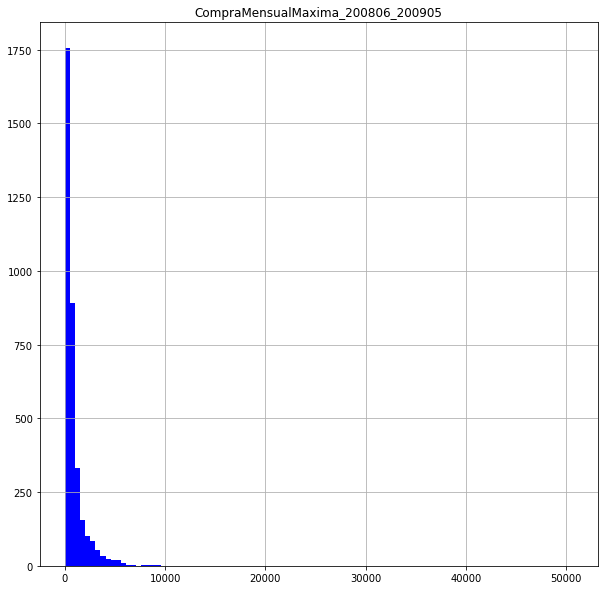

In [30]:
for cat in feature_columns["numerical"]:
  #plt.figure(figsize=(15,8))
  #sns.distplot(Train_Balanceado[cat], kde=False, rug=True)
  Train_Balanceado[cat].hist(figsize=(10,10),color="blue",bins=100)
  plt.title(cat)
  plt.show()
  import gc
  gc.collect()

In [31]:
import gc
gc.collect()

0

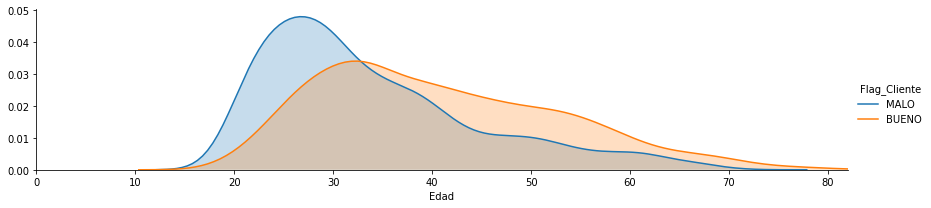

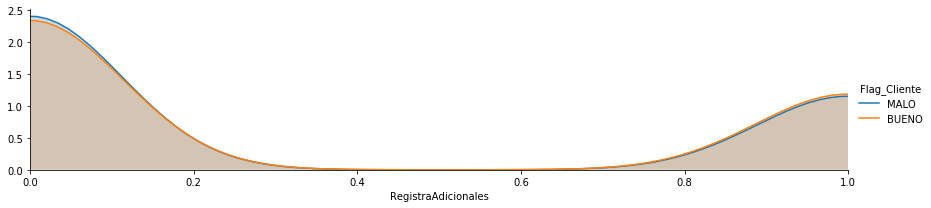

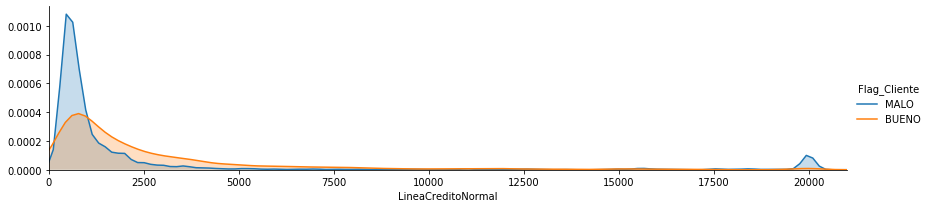

In [26]:
for cat in feature_columns["numerical"][0:3]:
  a = sns.FacetGrid(Train_Balanceado[[cat,"Flag_Cliente"]], hue = 'Flag_Cliente', aspect=4)
  a.map(sns.kdeplot, cat, shade= True )
  a.set(xlim=(0 , Train_Balanceado[cat].max()))
  a.add_legend()
  gc.collect()
  #plt.show()
  #print('Skew for train data:',Train_Balanceado.Renta.skew())
  del a
  gc.collect()

In [0]:
for cat in feature_columns["numerical"][3:6]:
  a = sns.FacetGrid(Train_Balanceado[[cat,"Flag_Cliente"]], hue = 'Flag_Cliente', aspect=4)
  a.map(sns.kdeplot, cat, shade= True )
  a.set(xlim=(0 , Train_Balanceado[cat].max()))
  a.add_legend()
  gc.collect()
  #plt.show()
  #print('Skew for train data:',Train_Balanceado.Renta.skew())
  del a
  gc.collect()

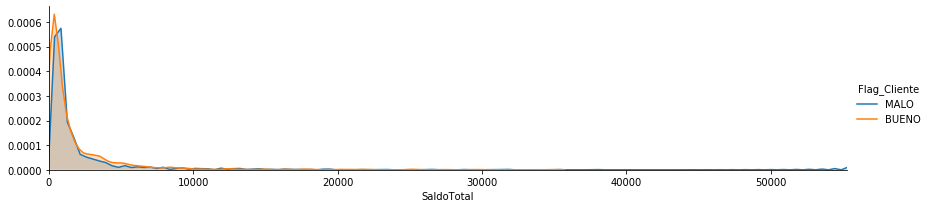

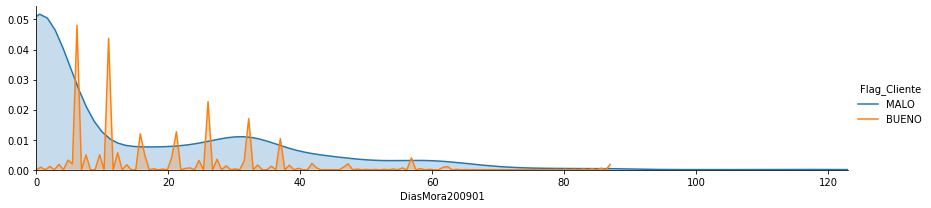

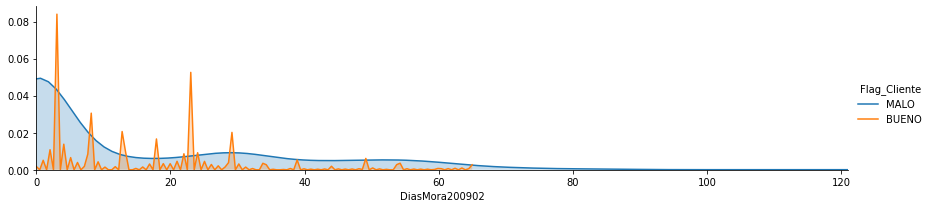

In [34]:
for cat in feature_columns["numerical"][6:9]:
  a = sns.FacetGrid(Train_Balanceado[[cat,"Flag_Cliente"]], hue = 'Flag_Cliente', aspect=4)
  a.map(sns.kdeplot, cat, shade= True )
  a.set(xlim=(0 , Train_Balanceado[cat].max()))
  a.add_legend()
  gc.collect()
  #plt.show()
  #print('Skew for train data:',Train_Balanceado.Renta.skew())
  del a
  gc.collect()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f3227d98a20>]],
      dtype=object)

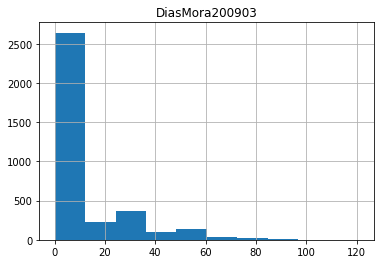

In [26]:
Train_Balanceado[feature_columns["numerical"][9:10]].hist()

In [0]:
for cat in feature_columns["numerical"][9:10]:
  a = sns.FacetGrid(Train_Balanceado[[cat,"Flag_Cliente"]], hue = 'Flag_Cliente', aspect=4)
  a.map(sns.kdeplot, cat, shade= True )
  a.set(xlim=(0 , Train_Balanceado[cat].max()))
  a.add_legend()
  gc.collect()
  #plt.show()
  #print('Skew for train data:',Train_Balanceado.Renta.skew())
  del a
  gc.collect()

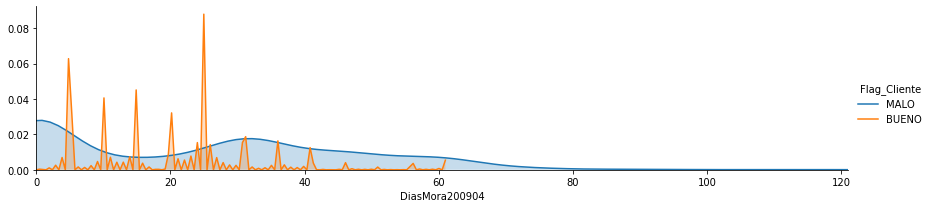

In [27]:
for cat in feature_columns["numerical"][10:11]:
  a = sns.FacetGrid(Train_Balanceado[[cat,"Flag_Cliente"]], hue = 'Flag_Cliente', aspect=4)
  a.map(sns.kdeplot, cat, shade= True )
  a.set(xlim=(0 , Train_Balanceado[cat].max()))
  a.add_legend()
  gc.collect()
  #plt.show()
  #print('Skew for train data:',Train_Balanceado.Renta.skew())
  del a
  gc.collect()

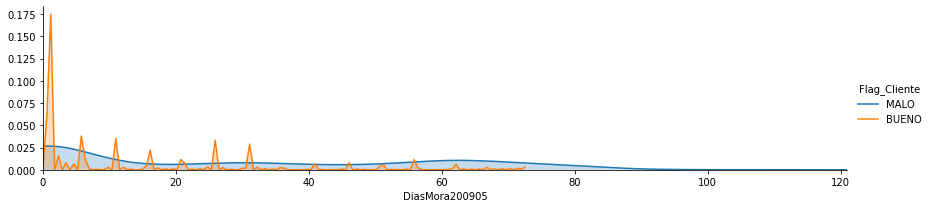

In [26]:
for cat in feature_columns["numerical"][11:12]:
  a = sns.FacetGrid(Train_Balanceado[[cat,"Flag_Cliente"]], hue = 'Flag_Cliente', aspect=4)
  a.map(sns.kdeplot, cat, shade= True )
  a.set(xlim=(0 , Train_Balanceado[cat].max()))
  a.add_legend()
  gc.collect()
  #plt.show()
  #print('Skew for train data:',Train_Balanceado.Renta.skew())
  del a
  gc.collect()

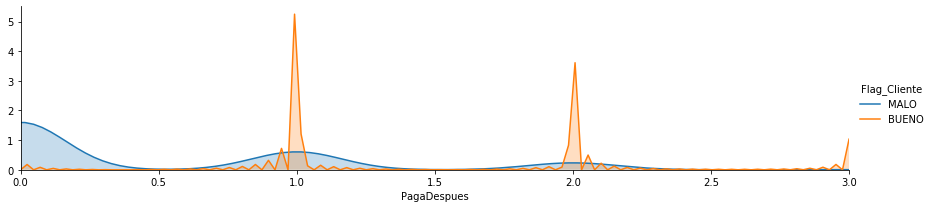

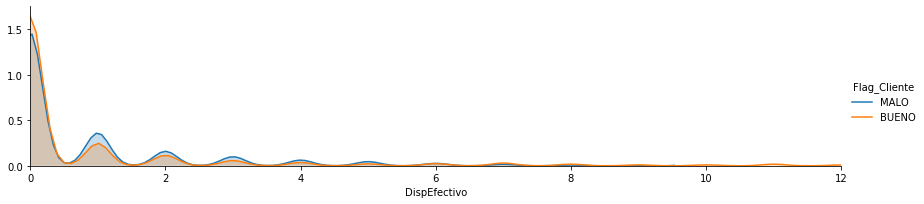

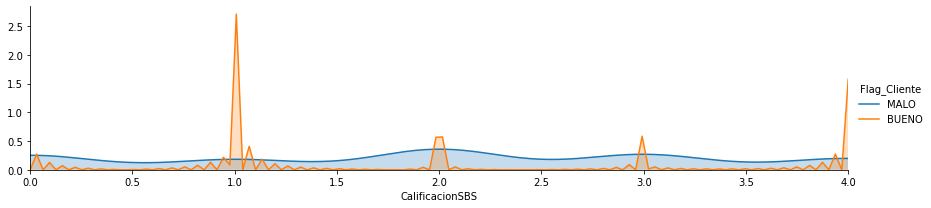

In [35]:
for cat in feature_columns["numerical"][12:15]:
  a = sns.FacetGrid(Train_Balanceado[[cat,"Flag_Cliente"]], hue = 'Flag_Cliente', aspect=4)
  a.map(sns.kdeplot, cat, shade= True )
  a.set(xlim=(0 , Train_Balanceado[cat].max()))
  a.add_legend()
  gc.collect()
  #plt.show()
  #print('Skew for train data:',Train_Balanceado.Renta.skew())
  del a
  gc.collect()

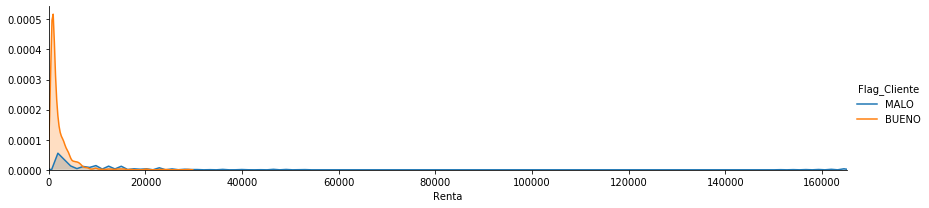

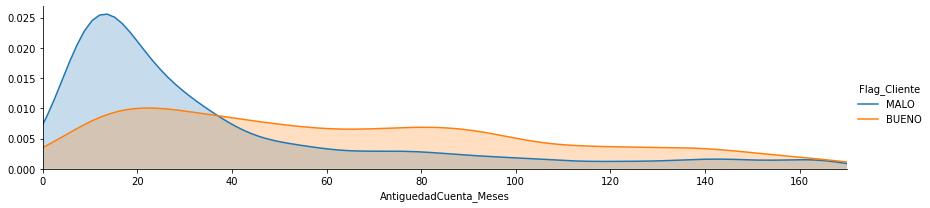

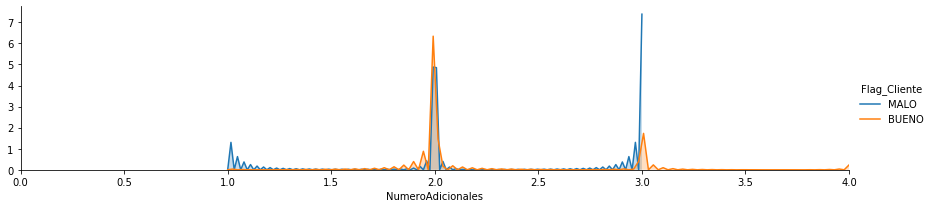

In [36]:
for cat in feature_columns["numerical"][15:18]:
  a = sns.FacetGrid(Train_Balanceado[[cat,"Flag_Cliente"]], hue = 'Flag_Cliente', aspect=4)
  a.map(sns.kdeplot, cat, shade= True )
  a.set(xlim=(0 , Train_Balanceado[cat].max()))
  a.add_legend()
  gc.collect()
  #plt.show()
  #print('Skew for train data:',Train_Balanceado.Renta.skew())
  del a
  gc.collect()

/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric/kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2
/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:30: UserWarning: Attempting to set identical left == right == 0 results in singular transformations; automatically expanding.
  ax.set(**kwargs)


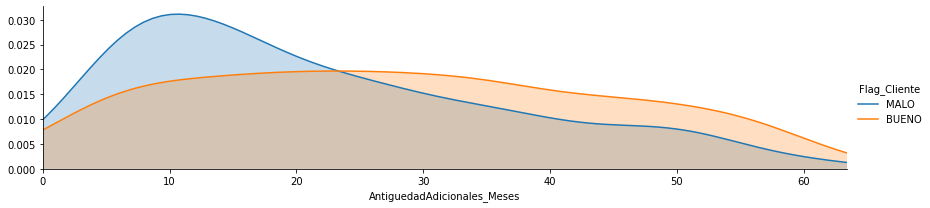

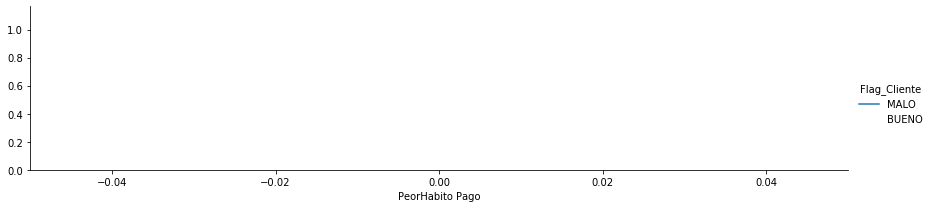

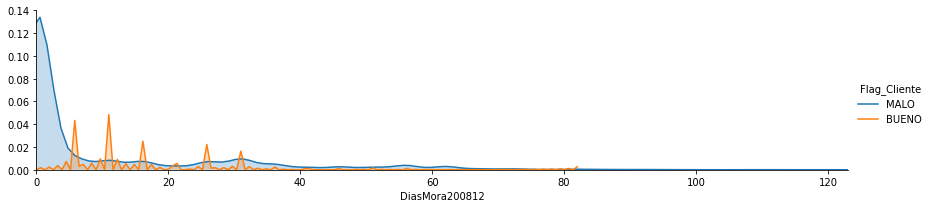

In [37]:
for cat in feature_columns["numerical"][18:21]:
  a = sns.FacetGrid(Train_Balanceado[[cat,"Flag_Cliente"]], hue = 'Flag_Cliente', aspect=4)
  a.map(sns.kdeplot, cat, shade= True )
  a.set(xlim=(0 , Train_Balanceado[cat].max()))
  a.add_legend()
  gc.collect()
  #plt.show()
  #print('Skew for train data:',Train_Balanceado.Renta.skew())
  del a
  gc.collect()

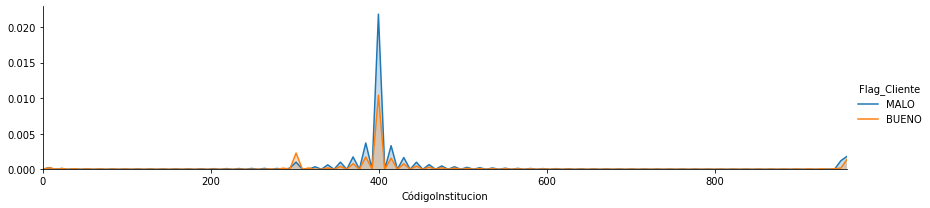

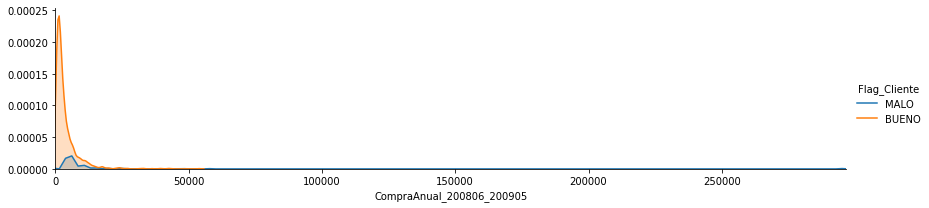

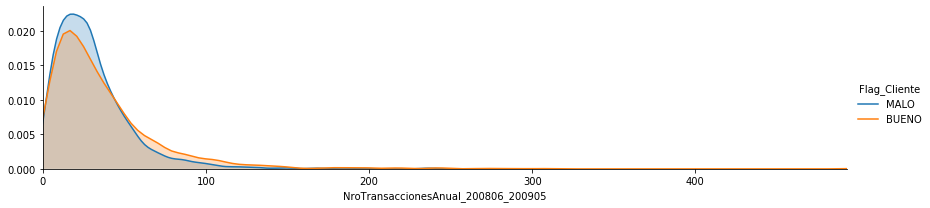

In [38]:
for cat in feature_columns["numerical"][21:24]:
  a = sns.FacetGrid(Train_Balanceado[[cat,"Flag_Cliente"]], hue = 'Flag_Cliente', aspect=4)
  a.map(sns.kdeplot, cat, shade= True )
  a.set(xlim=(0 , Train_Balanceado[cat].max()))
  a.add_legend()
  gc.collect()
  #plt.show()
  #print('Skew for train data:',Train_Balanceado.Renta.skew())
  del a
  gc.collect()

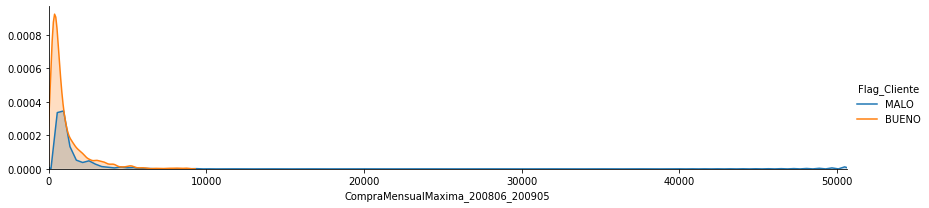

In [39]:
for cat in feature_columns["numerical"][24:]:
  a = sns.FacetGrid(Train_Balanceado[[cat,"Flag_Cliente"]], hue = 'Flag_Cliente', aspect=4)
  a.map(sns.kdeplot, cat, shade= True )
  a.set(xlim=(0 , Train_Balanceado[cat].max()))
  a.add_legend()
  gc.collect()
  #plt.show()
  #print('Skew for train data:',Train_Balanceado.Renta.skew())
  del a
  gc.collect()

In [639]:
#Creamos una función:
def num_missing(x):
  return sum(x.isnull())
#Aplicamos por columna:
print ("Valores perdidos por columna")
print (Train_Balanceado.apply(num_missing, axis=0)) 
print(Train_Balanceado.shape)

Valores perdidos por columna
Cliente                                   0
Edad                                      0
Renta                                  1785
Sexo                                      0
EstadoCivil                               0
NivelSocioEconomico                       0
Departamento                              0
AntiguedadCuenta_Meses                    0
RegistraAdicionales                       0
NumeroAdicionales                      2374
AntiguedadAdicionales_Meses            2374
LineaCreditoNormal                        0
SituacionCuenta                           0
PromediodePagos                           0
SaldoExtra                                0
SaldoNormal                               0
SaldoTotal                                0
HabitodePago1                             0
HabitodePago2                             0
HabitodePago3                             0
HabitodePago4                             1
HabitodePago5                             8
Hab

In [640]:
mean = np.mean(list(Train_Balanceado["Renta"].dropna())+list(Test["Renta"].dropna()))
Train_Balanceado["Renta"]=Train_Balanceado["Renta"].fillna(value=mean)
Test["Renta"]=Test["Renta"].fillna(value=mean)
mean =np.mean(list(Train_Balanceado["CompraMensualMaxima_200806_200905"].dropna())+list(Test["CompraMensualMaxima_200806_200905"].dropna()))
Train_Balanceado["CompraMensualMaxima_200806_200905"]=Train_Balanceado["CompraMensualMaxima_200806_200905"].fillna(value=mean)
Test["CompraMensualMaxima_200806_200905"]=Test["CompraMensualMaxima_200806_200905"].fillna(value=mean)
mean =np.mean(list(Train_Balanceado["AntiguedadAdicionales_Meses"].dropna())+list(Test["AntiguedadAdicionales_Meses"].dropna()))
Train_Balanceado["AntiguedadAdicionales_Meses"]=Train_Balanceado["AntiguedadAdicionales_Meses"].fillna(value=mean)
Test["AntiguedadAdicionales_Meses"]=Test["AntiguedadAdicionales_Meses"].fillna(value=mean)
###############################################################################################################

for cat in ["NumeroAdicionales"] + ["HabitodePago4"]+["HabitodePago5"]+["HabitodePago6"]+["HabitodePago7"]+["HabitodePago8"]+["PeorHabito Pago"]+["DiasMora200812"]+["CódigoInstitucion"]+["CompraAnual_200806_200905"]+["NroTransaccionesAnual_200806_200905"]:
  #mode=mode(list(Train_Balanceado[cat].dropna())+list(Test[cat].dropna()))
  mode=pd.DataFrame(np.asarray( list(Train_Balanceado[cat].dropna())+list(Test[cat].dropna()))).mode().values
  Train_Balanceado[cat]=Train_Balanceado[cat].fillna(value=Train_Balanceado[cat].value_counts().index[0])
  Test[cat]=Test[cat].fillna(value=Test[cat].value_counts().index[0])
       

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead



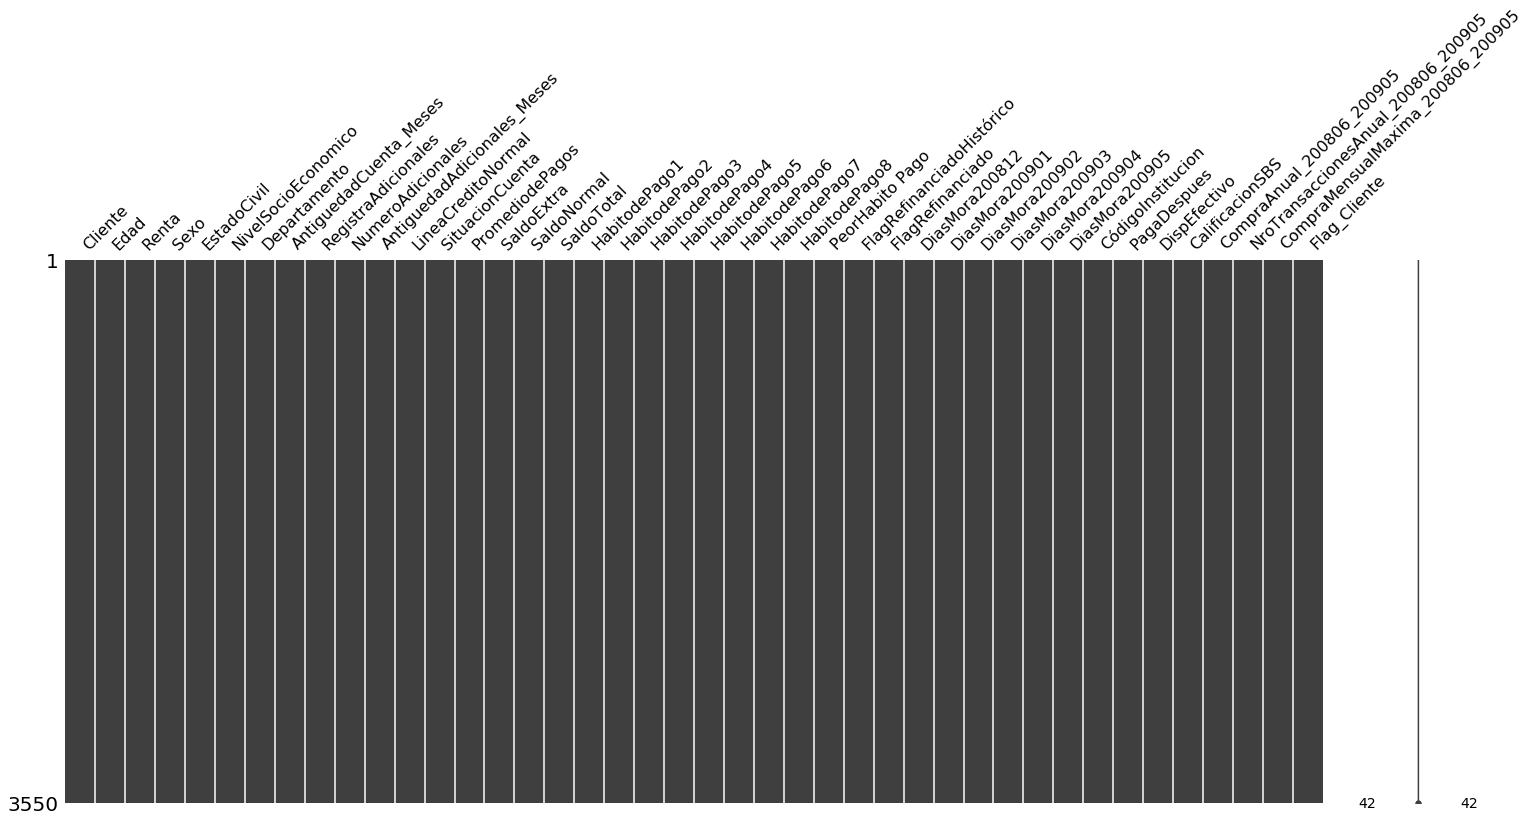

In [641]:
import missingno as msno
msno.matrix(Test)

In [642]:
test=Test.copy()
train=Train_Balanceado.copy()
for l in feature_columns["categorical"] +["Flag_Cliente"]:
    
    print(l)
    
    
    me = preprocessing.LabelEncoder()
    
    train.loc[train[l].notnull(),l]=train.loc[train[l].notnull(),l].astype(str)
    
    test.loc[test[l].notnull(),l]=test.loc[test[l].notnull(),l].astype(str)

    
    me.fit(list(train[l].dropna())+list(test[l].dropna()))
    
    

    train.loc[~train[l].isnull(),l]=me.transform(train.loc[~train[l].isnull(),l])

    test.loc[~test[l].isnull(),l]=me.transform(test.loc[~test[l].isnull(),l])
test=test.drop('Flag_Cliente', axis=1)

Sexo
EstadoCivil
NivelSocioEconomico
Departamento
PromediodePagos
HabitodePago1
HabitodePago2
HabitodePago3
HabitodePago4
HabitodePago5
HabitodePago6
HabitodePago7
HabitodePago8
FlagRefinanciadoHistórico
FlagRefinanciado
Flag_Cliente


In [643]:
test.head(1)

,Cliente,Edad,Renta,Sexo,EstadoCivil,NivelSocioEconomico,Departamento,AntiguedadCuenta_Meses,RegistraAdicionales,NumeroAdicionales,AntiguedadAdicionales_Meses,LineaCreditoNormal,SituacionCuenta,PromediodePagos,SaldoExtra,SaldoNormal,SaldoTotal,HabitodePago1,HabitodePago2,HabitodePago3,HabitodePago4,HabitodePago5,HabitodePago6,HabitodePago7,HabitodePago8,PeorHabito Pago,FlagRefinanciadoHistórico,FlagRefinanciado,DiasMora200812,DiasMora200901,DiasMora200902,DiasMora200903,DiasMora200904,DiasMora200905,CódigoInstitucion,PagaDespues,DispEfectivo,CalificacionSBS,CompraAnual_200806_200905,NroTransaccionesAnual_200806_200905,CompraMensualMaxima_200806_200905
573,676110,78,893.0,0,2,4,6,93.3,1,1.0,39.23,600,5,4,0,744,744,6,3,5,3,2,1,2,2,0.0,0,0,0.0,11,39,11,41,72,0.0,1,3,2,1897.45,47.0,502.13


In [0]:
no_usar=["Flag_Cliente"]+["Cliente"]		
features=[x for x in train.columns if x not in no_usar]
cat_ind=[features.index(x) for x in feature_columns["categorical"]]

In [645]:
cat_ind

[2, 3, 4, 5, 12, 16, 17, 18, 19, 20, 21, 22, 23, 25, 26]

# **APLICANDO EL MODELO LIGHT GBM CON CROSS VALIDATION**

In [646]:

kf_previo=StratifiedKFold(n_splits=5,random_state=256,shuffle=True)

i=1

r=[]

importancias=[]

for train_index,test_index in kf_previo.split(train,train['Flag_Cliente']):

    lgb_train = lgb.Dataset(train.loc[train_index,features].values,train.loc[train_index,'Flag_Cliente'].values.ravel())
    lgb_eval = lgb.Dataset(train.loc[test_index,features].values,train.loc[test_index,'Flag_Cliente'].values.ravel(), reference=lgb_train)

    params = {
         'task': 'train',
        'boosting_type': 'gbdt',
        'objective': 'binary',
        'metric': { 'auc'},
        "max_depth":4,
        "num_leaves":10,
        'learning_rate': 0.1,
    "min_child_samples": 100,
        'feature_fraction': 0.5,
     "bagging_freq":1,
        'bagging_fraction': 0.9,
        "lambda_l1":1,
        "lambda_l2":1,
       # "scale_pos_weight":30,

        'verbose': 1     
    }


    lgbm3 = lgb.train(
        params,lgb_train,
        num_boost_round=13100,
        valid_sets=lgb_eval,
        early_stopping_rounds=50,
        verbose_eval=25,
        categorical_feature=cat_ind)
    
    test["TARGET_FOLD"+str(i)]=lgbm3.predict(test[features].values, num_iteration=lgbm3.best_iteration)
    
    importancia=lgbm3.feature_importance(importance_type="gain")
    
    importancias.append(importancia)
    
    print ("Fold_"+str(i))
    a= (roc_auc_score(train.loc[test_index,'Flag_Cliente'],lgbm3.predict(train.loc[test_index,features].values, num_iteration=lgbm3.best_iteration)))
    
    #train.loc[test_index,"probabilidad"]=lgbm3.predict(train.loc[test_index,features].values, num_iteration=lgbm3.best_iteration)
    
    
    r.append(a)
    print (a)
    print ("")
    
    i=i+1

print ("mean: "+str(np.mean(np.array(r))))
print ("std: "+str(np.std(np.array(r))))

/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [2, 3, 4, 5, 12, 16, 17, 18, 19, 20, 21, 22, 23, 25, 26]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 50 rounds.
[25]	valid_0's auc: 0.958143
[50]	valid_0's auc: 0.965483
[75]	valid_0's auc: 0.968022
[100]	valid_0's auc: 0.969879
[125]	valid_0's auc: 0.969633
[150]	valid_0's auc: 0.970458
[175]	valid_0's auc: 0.970427
[200]	valid_0's auc: 0.970514
Early stopping, best iteration is:
[158]	valid_0's auc: 0.97076
Fold_1
0.9707597698869272

Training until validation scores don't improve for 50 rounds.
[25]	valid_0's auc: 0.958611
[50]	valid_0's auc: 0.969871
[75]	valid_0's auc: 0.974418
[100]	valid_0's auc: 0.976743
[125]	valid_0's auc: 0.977155


/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [2, 3, 4, 5, 12, 16, 17, 18, 19, 20, 21, 22, 23, 25, 26]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


[150]	valid_0's auc: 0.977981
[175]	valid_0's auc: 0.977235
[200]	valid_0's auc: 0.977155
Early stopping, best iteration is:
[152]	valid_0's auc: 0.9781
Fold_2
0.9780995834159889

Training until validation scores don't improve for 50 rounds.
[25]	valid_0's auc: 0.977856
[50]	valid_0's auc: 0.982799
[75]	valid_0's auc: 0.985509
[100]	valid_0's auc: 0.986434


/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [2, 3, 4, 5, 12, 16, 17, 18, 19, 20, 21, 22, 23, 25, 26]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


[125]	valid_0's auc: 0.987448
[150]	valid_0's auc: 0.987256
[175]	valid_0's auc: 0.987041
[200]	valid_0's auc: 0.987105
Early stopping, best iteration is:
[158]	valid_0's auc: 0.987559
Fold_3
0.9875594497111304

Training until validation scores don't improve for 50 rounds.
[25]	valid_0's auc: 0.960193
[50]	valid_0's auc: 0.968057


/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [2, 3, 4, 5, 12, 16, 17, 18, 19, 20, 21, 22, 23, 25, 26]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


[75]	valid_0's auc: 0.971265
[100]	valid_0's auc: 0.972095
[125]	valid_0's auc: 0.972525
[150]	valid_0's auc: 0.973315
[175]	valid_0's auc: 0.973395
[200]	valid_0's auc: 0.973555
[225]	valid_0's auc: 0.973483
[250]	valid_0's auc: 0.973355
Early stopping, best iteration is:
[210]	valid_0's auc: 0.973754
Fold_4
0.9737543490057134

Training until validation scores don't improve for 50 rounds.
[25]	valid_0's auc: 0.960847
[50]	valid_0's auc: 0.969002
[75]	valid_0's auc: 0.971376
[100]	valid_0's auc: 0.972302
[125]	valid_0's auc: 0.973164
[150]	valid_0's auc: 0.973746


/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [2, 3, 4, 5, 12, 16, 17, 18, 19, 20, 21, 22, 23, 25, 26]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


[175]	valid_0's auc: 0.973714
[200]	valid_0's auc: 0.973698
Early stopping, best iteration is:
[157]	valid_0's auc: 0.973842
Fold_5
0.9738421271026844

mean: 0.9768030558244888
std: 0.0058645376684899045


In [0]:
w=[x for x in test.columns if 'FOLD' in x]

test['Flag_Cliente']=test[w].mean(axis=1)


In [648]:
test.head(5)

,Cliente,Edad,Renta,Sexo,EstadoCivil,NivelSocioEconomico,Departamento,AntiguedadCuenta_Meses,RegistraAdicionales,NumeroAdicionales,AntiguedadAdicionales_Meses,LineaCreditoNormal,SituacionCuenta,PromediodePagos,SaldoExtra,SaldoNormal,SaldoTotal,HabitodePago1,HabitodePago2,HabitodePago3,HabitodePago4,HabitodePago5,HabitodePago6,HabitodePago7,HabitodePago8,PeorHabito Pago,FlagRefinanciadoHistórico,FlagRefinanciado,DiasMora200812,DiasMora200901,DiasMora200902,DiasMora200903,DiasMora200904,DiasMora200905,CódigoInstitucion,PagaDespues,DispEfectivo,CalificacionSBS,CompraAnual_200806_200905,NroTransaccionesAnual_200806_200905,CompraMensualMaxima_200806_200905,TARGET_FOLD1,TARGET_FOLD2,TARGET_FOLD3,TARGET_FOLD4,TARGET_FOLD5,Flag_Cliente
573,676110,78,893.000000,0,2,4,6,93.30,1,1.0,39.230000,600,5,4,0,744,744,6,3,5,3,2,1,2,2,0.0,0,0,0.0,11,39,11,41,72,0.0,1,3,2,1897.45,47.0,502.13,0.827663,0.787653,0.932475,0.860295,0.779349,0.837487
1592,1747726,29,2533.687658,0,2,3,7,28.40,0,1.0,25.052864,500,5,5,0,710,710,7,6,3,5,3,2,2,2,0.0,0,0,0.0,16,0,16,46,77,0.0,0,2,3,2196.00,46.0,487.60,0.986900,0.990757,0.986131,0.990276,0.988313,0.988475
3675,1742315,47,2547.000000,0,2,2,7,28.63,0,1.0,25.052864,1000,5,7,0,834,834,7,6,3,5,3,5,3,5,0.0,1,1,0.0,26,0,26,56,0,0.0,0,1,0,2705.66,40.0,763.78,0.698871,0.587461,0.614458,0.394375,0.414911,0.542015
2774,2137934,31,796.000000,1,2,3,7,11.60,0,1.0,25.052864,500,5,7,0,443,443,7,6,3,5,6,6,3,4,0.0,0,0,1.0,1,0,31,61,62,0.0,0,0,3,958.85,20.0,250.60,0.999082,0.998889,0.997974,0.999220,0.999374,0.998908
2134,1962156,30,1435.000000,0,2,3,7,18.63,1,1.0,12.030000,700,5,6,0,911,911,6,3,3,6,6,6,3,1,0.0,0,0,31.0,0,0,1,31,62,0.0,2,2,2,1137.04,45.0,270.82,0.998366,0.997673,0.999066,0.998930,0.998487,0.998505


In [649]:
roc_auc_score(Test['Flag_Cliente'],test['Flag_Cliente'])

0.9801676878426314

# **APLICANDO EL MODELO DE REGRESIÓN LOGÍSTICA CON CROSS VALIDATION**

In [650]:
from sklearn.linear_model import LogisticRegression
LogisticRegression()

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [0]:
model_rlog = LogisticRegression(C=5, max_iter= 500, random_state=0, n_jobs = 4, penalty = 'l1') 

In [652]:

kf_previo=StratifiedKFold(n_splits=5,random_state=256,shuffle=True)

i=1

r=[]

importancias=[]

for train_index,test_index in kf_previo.split(train,train['Flag_Cliente']):

    model_rlog.fit(train.loc[train_index,features], train.loc[train_index,'Flag_Cliente'])
    model = model_rlog
    test["TARGET_FOLD_R"]=model.predict_proba(test[features])[:,1]
    print ("Fold_"+str(i))
    a= (roc_auc_score(train.loc[test_index,'Flag_Cliente'],model.predict_proba(train.loc[test_index,features])[:,1]))
    r.append(a)
    print (a)
    print ("")
    i=i+1

print ("mean: "+str(np.mean(np.array(r))))
print ("std: "+str(np.std(np.array(r))))

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


Fold_1
0.9552945844078555

Fold_2
0.9545090259869073



/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


Fold_3
0.9683599859555044

Fold_4
0.9522806345558429

Fold_5
0.9604918765361167

mean: 0.9581872214884454
std: 0.005754664410909546


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


In [0]:
w=[x for x in test.columns if 'FOLD' in x]

Y_predict=test[w].mean(axis=1)


In [654]:
roc_auc_score(Test['Flag_Cliente'],Y_predict)

0.9795087690788087

# **HACIENDO EMSAMBLE DEL MODELO LIGHT GBM Y DE REGRESIÓN LOGÍSTICA**

In [0]:
from scipy import optimize


In [0]:
def scalar1(x):
    return (-1*roc_auc_score(Test['Flag_Cliente'],(test['Flag_Cliente']*(x)+ Y_predict*(1-x))))     

In [0]:

# Left-sided inequality from the first constraint
result = optimize.minimize_scalar(scalar1, bounds = (0,1),method='Bounded')
    

In [658]:
print(result)

     fun: -0.9801537223196987
 message: 'Solution found.'
    nfev: 21
  status: 0
 success: True
       x: 0.9580571733789083


In [0]:
Emsamble_test=(test['Flag_Cliente']*(result.x)+Y_predict*(1-result.x))

In [660]:
roc_auc_score(Test['Flag_Cliente'],Emsamble_test)

0.9801537223196987

In [661]:
print(str(roc_auc_score(Test['Flag_Cliente'],test['Flag_Cliente'])),'--',str(roc_auc_score(Test['Flag_Cliente'],Y_predict)),'--',str(roc_auc_score(Test['Flag_Cliente'],Emsamble_test)))

0.9801676878426314 -- 0.9795087690788087 -- 0.9801537223196987
